<a href="https://colab.research.google.com/github/MaidinuerSaimi/Python-courses/blob/main/Assignment_2_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is assignment 2, submitted by Max Kolke and Maidinuer Saimi (pair 5).**

## Assignment 2 - Mortality in the ICU

In this assignment, we are going to build a predictive model for mortality in ICU patients, using a database of 1010 patients and various measurements taken at admission and throughout their first 7 days of their stay at the UMCG ICU (courtesy of Dr Eric Keus).  Mortality outcomes at ICU and at several time points afterwards are included.

This problem is different from the one we tackled in the first part of this week in various ways. First, the target variable is not a continuous variable (heart valve size), but a binary outcome (mortality). This is therefore a *classification* problem. In keeping with the approach taken earlier, we will use a classic model to tackle this problem, namely, logistic regression.

There are other differences as well. There are now very many more predictive variables available, increasing the risk of over-fitting.  Therefore, regularization is important (and cross-validation remains important to assess the quality of our models properly).

The dataset is also somewhat messy - again, this is actual data, and this messiness is to be expected. Some variables have very few entries and should be skipped. Some variables pertain to days 2 and onwards; we will focus on the prediction problem at admission and we will not use those. Many variables have at least some missing data and we will need to deal with that.

<div class="alert alert-success">

## Assignment

* Your overall task is to build the **best predictive model** you can find for 7-day ICU mortality.
* As a figure of merit, use the area under the ROC curve ("roc_auc").
* To make things comparable, use simple 5-fold cross-validation.
* Deadline for submission of (runnable code, clearly annotated with running English text) .ipynb: **Thursday 17:00**
* You are asked to work in pairs. Please include **both your names** in the filename of the notebook you submit.

While you're entirely free to come up with your own strategy, here are some ideas:

* Start with logistic regression and use a validation curve to find the optimal regularization strength.
* Consider adding quadratic and mixed terms for the important parameters.
* Try some tree-based and other classifiers implemented in Scikit-learn.
* Try XGBoost - you will (probably) need to install it first. Try modifying some hyperparameters.

# 1. Introduction

# 2. Preprocessing

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

In [ ]:
# First, we import the 'icu_data.csv' file.

from google.colab import files
files.upload();

Saving icu_data.csv to icu_data (1).csv


In [ ]:
# We load the data.
df = pd.read_csv("icu_data.csv")

# We remove all columns pertaining to measurements after the first day
# of admission, and we also remove the meaningless index column.
to_remove = ["Unnamed: 0"]
for var in df.columns:
    if var.find('_d') > -1 and var.find('_d1') == -1:
        to_remove.append(var)
df = df.drop( columns = to_remove )

# We get an overview of the features in the dataset.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1010 non-null   int64  
 1   gender                  1010 non-null   int64  
 2   height                  973 non-null    float64
 3   weight                  1010 non-null   float64
 4   bsa                     973 non-null    float64
 5   diabetes_sics           1010 non-null   int64  
 6   hypertension            1010 non-null   int64  
 7   previousmi              1010 non-null   int64  
 8   previousrenalfailure    1010 non-null   int64  
 9   confirmedinfection      1010 non-null   int64  
 10  gcs_d1                  958 non-null    float64
 11  pao2_d1                 937 non-null    float64
 12  fio2_d1                 958 non-null    float64
 13  mech_vent_d1            958 non-null    object 
 14  special_vent_method_d1  957 non-null    

In [ ]:
# We get an overview of the sample values.
df.describe()

,age,gender,height,weight,bsa,diabetes_sics,hypertension,previousmi,previousrenalfailure,confirmedinfection,...,cv_d1_SOFA,gcs_d1_sofa,creat_d1_SOFA,tot_d1_SOFA,max_SOFA,mort_icu,mort7,mort30,mort90,mort180
count,1010.000000,1010.000000,973.000000,1010.000000,973.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,...,939.000000,994.000000,964.000000,810.000000,916.000000,1010.000000,1009.000000,1000.000000,999.000000,999.000000
mean,60.628713,1.623762,175.591675,81.247921,1.963015,1.188119,1.305941,1.129703,1.091089,1.192079,...,1.826411,0.382294,0.475104,4.895062,6.271834,1.163366,1.133796,1.220000,0.263263,0.286286
std,15.443422,0.484681,9.974955,17.942156,0.229557,0.391001,0.461033,0.336143,0.287878,0.394130,...,1.353628,1.022766,0.805229,2.711072,2.999328,0.369883,0.340602,0.414454,0.440625,0.452251
min,18.000000,1.000000,125.000000,41.000000,1.317000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,52.000000,1.000000,169.000000,70.000000,1.810000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,3.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,64.000000,2.000000,175.000000,80.000000,1.966000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,5.000000,6.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,72.000000,2.000000,183.000000,90.250000,2.106000,1.000000,2.000000,1.000000,1.000000,1.000000,...,3.000000,0.000000,1.000000,6.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,2.000000,207.000000,168.000000,2.677000,2.000000,2.000000,2.000000,2.000000,2.000000,...,4.000000,4.000000,3.000000,16.000000,16.000000,2.000000,2.000000,2.000000,1.000000,1.000000


**Step 1**: Confirm target: we see 'mort7','mort30','mort90','mort180'.Among these,'mort7'is our target,so we should remove the rest;

The colmuns: mort_icu / mort30 / mort90 / mort180 are only used as supplementary ending information and are not used for prediction.

In [ ]:
# Checking the missing ratio of each variables
missing_ratio = df.isna().mean().sort_values(ascending=False)
print(missing_ratio)

uo_d1                     0.987129
MAP_d1                    0.421782
tot_d1_SOFA               0.198020
max_SOFA                  0.093069
bili_d1                   0.081188
bili_d1_SOFA              0.081188
resp_d1_SOFA              0.075248
resp_d1_amount            0.073267
pao2_d1                   0.072277
cv_d1_SOFA                0.070297
vam_d1                    0.052475
dap_d1                    0.052475
special_vent_method_d1    0.052475
fio2_d1                   0.051485
sap_d1                    0.051485
mech_vent_d1              0.051485
gcs_d1                    0.051485
creat_d1_SOFA             0.045545
height                    0.036634
bsa                       0.036634
platelets_d1_SOFA         0.022772
platelets_d1              0.020792
gcs_d1_sofa               0.015842
creat_d1                  0.014851
mort90                    0.010891
mort180                   0.010891
mort30                    0.009901
mort7                     0.000990
age                 

In [ ]:
# We define 'mort7' as the target.
target = 'mort7'

# We identify all columns to remove: every column that contains 'mort',
# but not 'mort7', and 'max_SOFA'.
to_drop = [col for col in df.columns if (col.startswith('mort') and col != target) or col == 'max_SOFA']

# We drop these columns.
df = df.drop(columns=to_drop)

# We check the result.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1010 non-null   int64  
 1   gender                  1010 non-null   int64  
 2   height                  973 non-null    float64
 3   weight                  1010 non-null   float64
 4   bsa                     973 non-null    float64
 5   diabetes_sics           1010 non-null   int64  
 6   hypertension            1010 non-null   int64  
 7   previousmi              1010 non-null   int64  
 8   previousrenalfailure    1010 non-null   int64  
 9   confirmedinfection      1010 non-null   int64  
 10  gcs_d1                  958 non-null    float64
 11  pao2_d1                 937 non-null    float64
 12  fio2_d1                 958 non-null    float64
 13  mech_vent_d1            958 non-null    object 
 14  special_vent_method_d1  957 non-null    

From (df.info()) we know:


*   uo_d1: 13 / 1010 Non-missing.The missing data rate is ~98.7%, almost all of them are missing
*   MAP_d1: 584 / 1010 (Non-missing):Missing rate ~ 42%
*   Other variables we should keep in following analysis.

In [ ]:
# We drop the variable with huge missingness: 'uo_d1'.
df = df.drop(columns=['uo_d1'])

# We drop the rows where the outcome 'mort7' is missing.
df = df.dropna(subset=['mort7'])

# We check the result.
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1009 entries, 0 to 1009
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1009 non-null   int64  
 1   gender                  1009 non-null   int64  
 2   height                  972 non-null    float64
 3   weight                  1009 non-null   float64
 4   bsa                     972 non-null    float64
 5   diabetes_sics           1009 non-null   int64  
 6   hypertension            1009 non-null   int64  
 7   previousmi              1009 non-null   int64  
 8   previousrenalfailure    1009 non-null   int64  
 9   confirmedinfection      1009 non-null   int64  
 10  gcs_d1                  957 non-null    float64
 11  pao2_d1                 936 non-null    float64
 12  fio2_d1                 957 non-null    float64
 13  mech_vent_d1            957 non-null    object 
 14  special_vent_method_d1  956 non-null    float

In [ ]:
# Now, we have to deal with missing data in several variables.
# We use imputation to handle this issue.
from sklearn.impute import SimpleImputer

# We separate numerical and categorical columns.
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('mort7')  # exclude target
cat_cols = df.select_dtypes(include=['object']).columns

# We define the imputer for numerical columns: 'median', because it is
# more robust against outliers.
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# We define the imputer for categorical columns: 'most_frequent'.
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# We check the result.
print(df.isnull().sum())

age                       0
gender                    0
height                    0
weight                    0
bsa                       0
diabetes_sics             0
hypertension              0
previousmi                0
previousrenalfailure      0
confirmedinfection        0
gcs_d1                    0
pao2_d1                   0
fio2_d1                   0
mech_vent_d1              0
special_vent_method_d1    0
sap_d1                    0
dap_d1                    0
MAP_d1                    0
vam_d1                    0
platelets_d1              0
bili_d1                   0
creat_d1                  0
rrt_d1                    0
resp_d1_amount            0
resp_d1_SOFA              0
platelets_d1_SOFA         0
bili_d1_SOFA              0
cv_d1_SOFA                0
gcs_d1_sofa               0
creat_d1_SOFA             0
tot_d1_SOFA               0
mort7                     0
dtype: int64


**Encoding categorical variables**

We have one categorical column: `mech_vent_d1`. Logistic regression cannot handle string/object variables, so we need to convert it to numeric.

We use one-hot encoding (`get_dummies`) because:
* It avoids implying any ordinal relationship between categories (unlike `LabelEncoder`).
* Logistic regression interprets each dummy variable independently.
* This is standard practice for categorical variables with few unique values.

Compared to one-hot encoding, label encoding assigns integers to categories (e.g., A=0, B=1, C=2). This introduces an artificial order, which is not appropriate for non-ordinal ICU ventilation types. One-hot encoding creates separate binary columns for each category, which preserves the categorical nature.

In [ ]:
# We use 'drop_first=True' to avoid the "dummy variable trap", which occurs
# when one category can be perfectly predicted by the others (multicollinearity).
# If there are 'n' categories, we will create 'n-1' dummy columns.
# The omitted category is implicitly represented by all zeros.
df = pd.get_dummies(df, columns=['mech_vent_d1'], drop_first=True)

# We check the result to ensure encoding worked.
print(df.head())

    age  gender  height  weight    bsa  diabetes_sics  hypertension  \
0  31.0     2.0   167.0    65.0  1.731            1.0           1.0   
1  59.0     1.0   177.0    65.0  1.806            1.0           1.0   
2  38.0     2.0   188.0    72.5  1.976            1.0           1.0   
3  27.0     1.0   160.0    60.0  1.622            1.0           1.0   
4  51.0     2.0   182.0    86.0  2.075            1.0           1.0   

   previousmi  previousrenalfailure  confirmedinfection  ...  resp_d1_SOFA  \
0         1.0                   1.0                 2.0  ...           2.0   
1         1.0                   1.0                 1.0  ...           2.0   
2         1.0                   1.0                 1.0  ...           0.0   
3         1.0                   1.0                 1.0  ...           0.0   
4         1.0                   1.0                 1.0  ...           1.0   

   platelets_d1_SOFA  bili_d1_SOFA  cv_d1_SOFA  gcs_d1_sofa  creat_d1_SOFA  \
0                0.0      

The categorical column `mech_vent_d1` has been successfully converted into two dummy columns: `mech_vent_d1_1` and `mech_vent_d1_NIV`. The rest of the columns are numeric. The target variable `mort7` is still present as a separate column and ready for separation.

**Feature and target separation**

Now, we split the DataFrame into:
* `X` (features): all columns except `mort7`
* `y` (target): the `mort7` column

In [ ]:
X = df.drop('mort7', axis=1)  # all predictors：All columns except for the objective and other outcome variables.
y = df['mort7']               # the target variable

# We check the result.
print(X.head())
print(y.head())

    age  gender  height  weight    bsa  diabetes_sics  hypertension  \
0  31.0     2.0   167.0    65.0  1.731            1.0           1.0   
1  59.0     1.0   177.0    65.0  1.806            1.0           1.0   
2  38.0     2.0   188.0    72.5  1.976            1.0           1.0   
3  27.0     1.0   160.0    60.0  1.622            1.0           1.0   
4  51.0     2.0   182.0    86.0  2.075            1.0           1.0   

   previousmi  previousrenalfailure  confirmedinfection  ...  resp_d1_amount  \
0         1.0                   1.0                 2.0  ...          33.000   
1         1.0                   1.0                 1.0  ...          34.800   
2         1.0                   1.0                 1.0  ...          71.905   
3         1.0                   1.0                 1.0  ...         105.455   
4         1.0                   1.0                 1.0  ...          51.667   

   resp_d1_SOFA  platelets_d1_SOFA  bili_d1_SOFA  cv_d1_SOFA  gcs_d1_sofa  \
0           2.0

**Feature scaling**

Logistic regression, support vector machines, and K-nearest neighbours are sensitive to feature scales Features like `age`, `weight`, and `MAP_d1` have very different ranges. Scaling ensures that each feature contributes equally to the model.


In [ ]:
from sklearn.preprocessing import StandardScaler

# We initialize the scaler. We use the 'StandardScaler()' because
# logistic regression uses a linear combination of features, and
# large-scale features can dominate small-scale ones if unscaled.
scaler = StandardScaler()

# We fit the scaler on the features 'X' and transform them.
# This centers each feature to 'mean'=0 and scales to unit variance (std=1)
X_scaled = scaler.fit_transform(X)

# We check the first few rows.
print(X_scaled[:5])

[[-1.92111548  0.77726028 -0.87503893 -0.90538474 -1.02976834 -0.48165364
  -0.66440091 -0.3862677  -0.31674462  2.04964166  0.59959762 -0.19457755
  -0.18132762 -0.05460867 -0.66083403 -0.33891473 -0.57073458 -0.78878799
  -0.49260879 -0.27510792  0.19425023 -0.16263347 -0.27764373  0.36059401
  -0.41689634 -0.37044244 -0.58178958 -0.37079683  0.68885011 -0.37761299
   0.90082747 -0.03149704]
 [-0.10673577 -1.28657031  0.14830945 -0.90538474 -0.69675244 -0.48165364
  -0.66440091 -0.3862677  -0.31674462 -0.48789016 -1.0816084  -0.27644374
  -1.141878   -0.05460867 -1.09808988 -1.3231754  -1.57631546 -0.78878799
  -0.43181548 -0.36737958 -0.51709195 -0.16263347 -0.20809282  0.36059401
  -0.41689634 -0.37044244 -1.33826597 -0.37079683 -0.57258321  0.03429134
  -1.11009049 -0.03149704]
 [-1.46752055  0.77726028  1.27399266 -0.48736572  0.05808361 -0.48165364
  -0.66440091 -0.3862677  -0.31674462 -0.48789016  0.59959762  0.06466536
  -1.141878   -0.05460867  1.62635041  0.38287643  1.53401

# 3. Logistic regression models

**3.1 Baseline logistic regression**

Logistic Regression is a classical linear model for binary classification. We define a baseline model to evaluate predictive performance before adding regularisation or interactions.

In [ ]:
# First, we import the required modules.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# In the 'baseline_model', we set 'max_iter=1000' to ensure convergence
# given our number of features.
baseline_model = LogisticRegression(max_iter=1000, solver='lbfgs')

# We use 5-fold cross-validation to evaluate the model.
# 'cv=5' splits data into 5 folds, each used once as a test set.
# We define 'scoring='roc_auc'' to evaluate the performance using
# the area under the ROC curve (AUC).
# 'cross_val_score' returns an array of 5 AUC scores, one per fold.
scores = cross_val_score(baseline_model, X_scaled, y, cv=5, scoring='roc_auc')

# We calculate the mean and standard deviation of the AUC across the folds.
print("Baseline Logistic Regression 5-fold CV ROC AUC:")
print(f"Mean AUC: {scores.mean():.3f}")
print(f"Stdev AUC: {scores.std():.3f}")

Baseline Logistic Regression 5-fold CV ROC AUC:
Mean AUC: 0.764
Stdev AUC: 0.033


**3.2 L1-regularised logistic regression (Lasso)**
L1-regularised logistic regression (Lasso) adds an L1 penalty on the coefficients.
Compared to the baseline logistic regression (which uses an L2 penalty by default), L1 regularisation tends to shrink many coefficients exactly to zero, effectively performing variable selection.
This is attractive in our ICU setting because we have many correlated predictors (e.g. overlapping SOFA components and raw lab values), and we would like a more parsimonious model that focuses on the most informative features.
The strength of regularisation is controlled by the parameter C:

*   small C → strong regularisation (more coefficients driven to zero),
*   large C → weak regularisation (model closer to the unregularised case).

In [ ]:
#Use cross-validation to create a "small validation curve" on a set of C values.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# We explore a range of C values on a logarithmic scale.
Cs = np.logspace(-3, 2, 8)  # from 0.001 to 100

mean_auc_l1 = []
std_auc_l1 = []

print("L1-regularised Logistic Regression (5-fold CV, ROC AUC):")
for C in Cs:
    l1_model = LogisticRegression(
        penalty='l1',
        C=C,
        solver='liblinear',   # supports L1 penalty
        max_iter=1000
    )
    scores = cross_val_score(l1_model, X_scaled, y, cv=5, scoring='roc_auc')
    mean_auc_l1.append(scores.mean())
    std_auc_l1.append(scores.std())
    print(f"C = {C:7.4f} | mean AUC = {scores.mean():.3f} | std = {scores.std():.3f}")

# Identify the best C value
best_idx = np.argmax(mean_auc_l1)
best_C_l1 = Cs[best_idx]
best_auc_l1 = mean_auc_l1[best_idx]

print("\nBest L1 model:")
print(f"Best C = {best_C_l1:.4f} with mean ROC AUC = {best_auc_l1:.3f}")


L1-regularised Logistic Regression (5-fold CV, ROC AUC):
C =  0.0010 | mean AUC = 0.500 | std = 0.000
C =  0.0052 | mean AUC = 0.500 | std = 0.000
C =  0.0268 | mean AUC = 0.708 | std = 0.026
C =  0.1389 | mean AUC = 0.790 | std = 0.028
C =  0.7197 | mean AUC = 0.776 | std = 0.029
C =  3.7276 | mean AUC = 0.764 | std = 0.033
C = 19.3070 | mean AUC = 0.760 | std = 0.036
C = 100.0000 | mean AUC = 0.759 | std = 0.036

Best L1 model:
Best C = 0.1389 with mean ROC AUC = 0.790


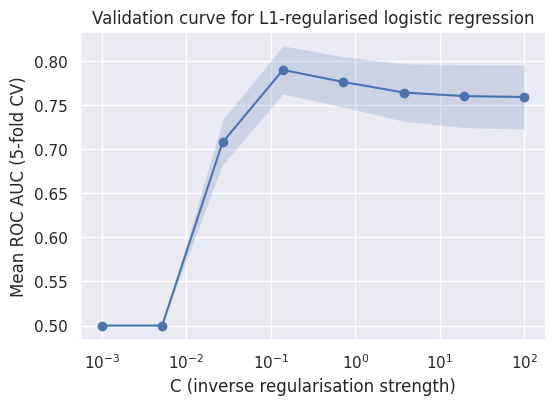

In [ ]:
# Plot the validation curve (C vs mean AUC)
plt.figure(figsize=(6,4))
plt.semilogx(Cs, mean_auc_l1, marker='o')
plt.fill_between(
    Cs,
    np.array(mean_auc_l1) - np.array(std_auc_l1),
    np.array(mean_auc_l1) + np.array(std_auc_l1),
    alpha=0.2
)
plt.xlabel("C (inverse regularisation strength)")
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.title("Validation curve for L1-regularised logistic regression")
plt.grid(True)
plt.show()


**Validation curve for L1-regularised logistic regression**

The plot shows how the mean 5-fold CV ROC AUC changes as we vary the inverse regularisation strength C for an L1-penalised logistic regression model.
For very small values of C , the AUC is close to 0.5, indicating that the model is heavily underfitting due to overly strong regularisation.
As C increases, the performance improves rapidly and reaches its maximum around C ≈ 0.1, with a mean ROC AUC of 0.790.
For larger C values (1–100), the AUC slightly decreases and then plateaus around 0.76–0.77, suggesting little or no further benefit from weakening the regularisation.
Compared to the baseline logistic regression with default L2 penalty (mean AUC ≈ 0.764), a moderate L1 penalty (C ≈ 0.1) yields a small improvement in discrimination while also enforcing sparsity in the coefficients.

**L2-regularised logistic regression (Ridge)**
In contrast to the L1 penalty, which can set some coefficients exactly to zero,  
**L2 regularisation (Ridge)** shrinks all coefficients smoothly towards zero but keeps them non-zero.

In our baseline logistic regression (Section 3.1), we already used the default L2 penalty with
**C = 1.0** (inverse regularisation strength). Here we explicitly tune **C** to see whether a
stronger or weaker L2 penalty can further improve performance.

As before, we use 5-fold cross-validation and ROC AUC as the figure of merit and evaluate
a range of C values on a logarithmic scale.

In [26]:
#L2-regularised logistic regression (Ridge) & Hyperparameter tuning (C)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Range of C values (same grid as for L1, for a fair comparison)
Cs_l2 = np.logspace(-3, 2, 8)  # 0.001 ... 100

mean_auc_l2 = []
std_auc_l2 = []

print("L2-regularised Logistic Regression (5-fold CV, ROC AUC):")
for C in Cs_l2:
    l2_model = LogisticRegression(
        penalty='l2',   # default, but we set it explicitly for clarity
        C=C,
        solver='lbfgs',
        max_iter=1000
    )
    scores = cross_val_score(l2_model, X_scaled, y, cv=5, scoring='roc_auc')
    mean_auc_l2.append(scores.mean())
    std_auc_l2.append(scores.std())
    print(f"C = {C:7.4f} | mean AUC = {scores.mean():.3f} | std = {scores.std():.3f}")

# Find the best C
best_idx_l2 = np.argmax(mean_auc_l2)
best_C_l2 = Cs_l2[best_idx_l2]
best_auc_l2 = mean_auc_l2[best_idx_l2]

print("\nBest L2 model:")
print(f"Best C = {best_C_l2:.4f} with mean ROC AUC = {best_auc_l2:.3f}")


L2-regularised Logistic Regression (5-fold CV, ROC AUC):
C =  0.0010 | mean AUC = 0.762 | std = 0.026
C =  0.0052 | mean AUC = 0.778 | std = 0.021
C =  0.0268 | mean AUC = 0.782 | std = 0.026
C =  0.1389 | mean AUC = 0.774 | std = 0.028
C =  0.7197 | mean AUC = 0.765 | std = 0.032
C =  3.7276 | mean AUC = 0.760 | std = 0.035
C = 19.3070 | mean AUC = 0.759 | std = 0.036
C = 100.0000 | mean AUC = 0.759 | std = 0.037

Best L2 model:
Best C = 0.0268 with mean ROC AUC = 0.782


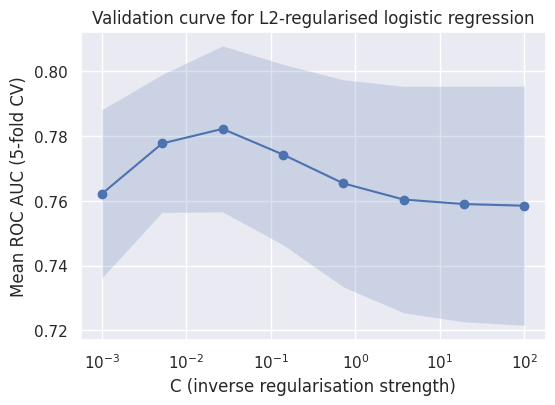

In [27]:
#Plot the validation curve for L2-regularised logistic regression
plt.figure(figsize=(6, 4))
plt.semilogx(Cs_l2, mean_auc_l2, marker='o')
plt.fill_between(
    Cs_l2,
    np.array(mean_auc_l2) - np.array(std_auc_l2),
    np.array(mean_auc_l2) + np.array(std_auc_l2),
    alpha=0.2
)
plt.xlabel("C (inverse regularisation strength)")
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.title("Validation curve for L2-regularised logistic regression")
plt.grid(True)
plt.show()


The validation curve for the L2-regularised logistic regression shows a clear
dependence of performance on the inverse regularisation strength **C**.

For very small C (strong regularisation, e.g. C = 0.001), the mean 5-fold CV
ROC AUC is around **0.762**, indicating a slightly underfitted model. As C
increases, the AUC improves and reaches a maximum of **0.782** at
**C = 0.0268**. For larger values of C (0.1–100), the AUC gradually decreases
and then plateaus around **0.759–0.765**, suggesting that weaker regularisation
does not provide any further benefit and may even slightly hurt performance.

Compared to the baseline logistic regression with default L2 penalty
(C = 1.0, mean AUC ≈ 0.764), tuning C to a moderate value (C ≈ 0.03) yields a
small but consistent improvement in discrimination for 7-day ICU mortality.

### 3.4 Logistic regression with polynomial & interaction terms
#### 3.4.1 Hyperparameter tuning (C)

In this section, we extend our previous logistic regression models by explicitly
modelling simple non-linear effects and interactions between a few clinically
important variables.

We select four continuous predictors:

- `age` (patient age),
- `sap_d1` (systolic arterial pressure on day 1),
- `MAP_d1` (mean arterial pressure on day 1),
- `tot_d1_SOFA` (total SOFA score on day 1),

and augment the feature space with:

- **Quadratic terms** (e.g. `age^2`, `sap_d1^2`),
- **Pairwise interaction terms** (e.g. `age × sap_d1`, `MAP_d1 × tot_d1_SOFA`).

This allows a logistic regression model to capture simple non-linear relationships
and interactions, while remaining relatively interpretable.

As before, we use L2-regularised logistic regression and perform hyperparameter
tuning of the inverse regularisation strength **C** using 5-fold cross-validation
and ROC AUC as the performance metric.


Shape before polynomial / interaction features : (1009, 32)
Shape after polynomial / interaction features  : (1009, 42)
Logistic regression with polynomial & interaction terms
L2-regularised (5-fold CV, ROC AUC):

C =  0.0010 | mean AUC = 0.748 | std = 0.024
C =  0.0052 | mean AUC = 0.771 | std = 0.023
C =  0.0268 | mean AUC = 0.780 | std = 0.023
C =  0.1389 | mean AUC = 0.773 | std = 0.024
C =  0.7197 | mean AUC = 0.764 | std = 0.027
C =  3.7276 | mean AUC = 0.757 | std = 0.030
C = 19.3070 | mean AUC = 0.754 | std = 0.031
C = 100.0000 | mean AUC = 0.754 | std = 0.031

Best polynomial LR model:
Best C = 0.0268 with mean ROC AUC = 0.780


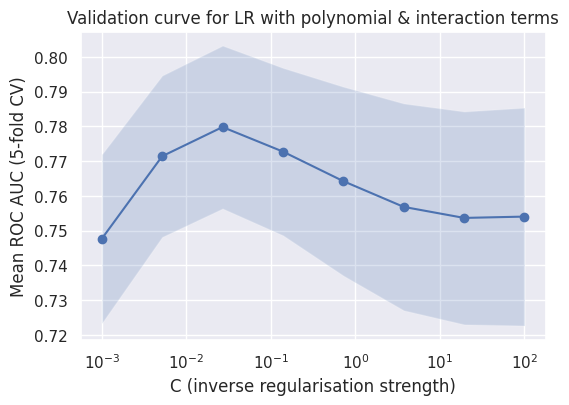

In [29]:
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# -------------------------------------------------------------------
# 3.4.1 Construct polynomial & interaction features
# -------------------------------------------------------------------

# We start from the original feature matrix X (after imputation and
# one-hot encoding, but BEFORE scaling).
# We create a copy so that we do not overwrite X by accident.
X_poly = X.copy()

# We select a small set of clinically important continuous variables.
# For these variables, we will create quadratic and pairwise interaction terms.
important_vars = ['age', 'sap_d1', 'MAP_d1', 'tot_d1_SOFA']

# 1) Quadratic terms: var^2
#    For each selected variable, we create a new column named "<var>_sq".
for var in important_vars:
    X_poly[f'{var}_sq'] = X_poly[var] ** 2

# 2) Pairwise interaction terms: var_i * var_j
#    For every pair of variables in 'important_vars', we create a new column
#    named "<var1>_x_<var2>" that is the product of the two variables.
for var1, var2 in combinations(important_vars, 2):
    X_poly[f'{var1}_x_{var2}'] = X_poly[var1] * X_poly[var2]

print("Shape before polynomial / interaction features :", X.shape)
print("Shape after polynomial / interaction features  :", X_poly.shape)

# -------------------------------------------------------------------
# 3.4.1 Scaling the expanded feature set
# -------------------------------------------------------------------

# Logistic regression with regularisation is sensitive to feature scales.
# We therefore standardise ALL features in X_poly:
#  - subtract the mean
#  - divide by the standard deviation (unit variance)
scaler_poly = StandardScaler()

# Fit the scaler on the expanded feature matrix and transform it.
# The result is a NumPy array with the same number of rows as X_poly.
X_poly_scaled = scaler_poly.fit_transform(X_poly)

# -------------------------------------------------------------------
# 3.4.1 Hyperparameter tuning for C (L2-regularised LR on X_poly)
# -------------------------------------------------------------------

# We now tune the inverse regularisation strength C for an L2-regularised
# logistic regression model, using the polynomial + interaction features.
# As before, we use 5-fold cross-validation and ROC AUC as the metric.

# Define a range of C values on a logarithmic scale
Cs_poly = np.logspace(-3, 2, 8)  # from 0.001 to 100

mean_auc_poly = []  # list to store mean AUC for each C
std_auc_poly = []   # list to store std of AUC for each C

print("Logistic regression with polynomial & interaction terms")
print("L2-regularised (5-fold CV, ROC AUC):\n")

for C in Cs_poly:
    # Define the logistic regression model with:
    #  - L2 penalty (Ridge-like)
    #  - current value of C (inverse regularisation strength)
    #  - 'lbfgs' solver (supports L2 and works well for this size)
    #  - max_iter increased to 1000 to ensure convergence
    logreg_poly = LogisticRegression(
        penalty='l2',
        C=C,
        solver='lbfgs',
        max_iter=1000
    )

    # Perform 5-fold cross-validation on the scaled polynomial features.
    # scoring='roc_auc' means we use the ROC AUC as our performance measure.
    scores = cross_val_score(
        logreg_poly,
        X_poly_scaled,
        y,
        cv=5,
        scoring='roc_auc'
    )

    # Store the mean and standard deviation of the AUC scores
    mean_auc_poly.append(scores.mean())
    std_auc_poly.append(scores.std())

    # Print the results for this particular C
    print(f"C = {C:7.4f} | mean AUC = {scores.mean():.3f} | std = {scores.std():.3f}")

# Identify the best C value based on the highest mean AUC
best_idx_poly = np.argmax(mean_auc_poly)
best_C_poly = Cs_poly[best_idx_poly]
best_auc_poly = mean_auc_poly[best_idx_poly]

print("\nBest polynomial LR model:")
print(f"Best C = {best_C_poly:.4f} with mean ROC AUC = {best_auc_poly:.3f}")

# -------------------------------------------------------------------
# 3.4.1 Plot the validation curve for polynomial LR
# -------------------------------------------------------------------

plt.figure(figsize=(6, 4))
plt.semilogx(Cs_poly, mean_auc_poly, marker='o')
plt.fill_between(
    Cs_poly,
    np.array(mean_auc_poly) - np.array(std_auc_poly),
    np.array(mean_auc_poly) + np.array(std_auc_poly),
    alpha=0.2
)
plt.xlabel("C (inverse regularisation strength)")
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.title("Validation curve for LR with polynomial & interaction terms")
plt.grid(True)
plt.show()


#### 3.4.1 Hyperparameter tuning (C)

The validation curve for the logistic regression model with polynomial and
interaction terms shows a similar pattern as for the purely linear L2 model.

For very small C (strong regularisation, e.g. C = 0.001), the mean 5-fold CV
ROC AUC is about **0.748**, indicating underfitting. As C increases, the
performance improves and reaches a maximum of **0.780** at
**C = 0.0268**. For larger C values (0.14–100), the AUC gradually decreases
and then plateaus around **0.754–0.764**, suggesting that weaker regularisation
does not provide any further benefit.

Compared to the baseline logistic regression with default L2 penalty
(C = 1.0, mean AUC ≈ 0.764), the polynomial model with tuned C achieves a
higher AUC (0.780). However, it does **not** outperform the best purely linear
L2-regularised model without polynomial terms (mean AUC ≈ 0.782 at C = 0.0268).
This indicates that, in this dataset, adding simple quadratic and interaction
terms for `age`, `sap_d1`, `MAP_d1`, and `tot_d1_SOFA` provides only limited
additional predictive value beyond the linear effects.


## 4. Tree-based models

Tree-based models can naturally capture non-linear relationships and interaction
effects between predictors. Unlike logistic regression, they do not require
feature scaling and are often easier to interpret (via tree structure or feature
importance).

Here we start with a simple **DecisionTreeClassifier**.

### 4.1 Decision Tree Classifier
#### 4.1.1 Hyperparameter tuning

A vanilla decision tree with no constraints tends to overfit, especially when
we have many predictors. Therefore, controlling tree complexity via
hyperparameters is crucial. We focus on:

- `max_depth`: the maximum depth of the tree (how many splits from root to leaf).
  Smaller values restrict the tree and reduce overfitting.
- `min_samples_leaf`: the minimum number of samples required in a leaf node.
  Larger values force leaves to contain more patients and make the tree smoother.

We perform a small grid search over these two hyperparameters using 5-fold
cross-validation and ROC AUC as our performance measure.


In [30]:
#Decision Tree + Hyperparameter Tuning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# -------------------------------------------------------------------
# 4.1.1 Hyperparameter tuning for DecisionTreeClassifier
# -------------------------------------------------------------------

# We will search over a small grid of hyperparameters:
# - max_depth: controls how "deep" the tree can grow (model complexity).
# - min_samples_leaf: minimum number of samples in each leaf node (smoothness).

max_depth_values = [2, 3, 4, 5, 6, 8, 10, None]   # None = no limit on depth
min_samples_leaf_values = [1, 5, 10]

results = []  # to collect all results (for later tabulation)

print("DecisionTreeClassifier (5-fold CV, ROC AUC):\n")

for max_depth in max_depth_values:
    for min_leaf in min_samples_leaf_values:
        # Define the decision tree with the current hyperparameters.
        # - random_state: fixed for reproducibility
        # - criterion='gini' (default) could also be 'entropy'; we keep defaults here.
        tree_clf = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_leaf,
            random_state=42
        )

        # Evaluate the model using 5-fold cross-validation and ROC AUC.
        scores = cross_val_score(
            tree_clf,
            X,       # we use the original feature matrix (no scaling needed)
            y,
            cv=5,
            scoring='roc_auc'
        )

        mean_auc = scores.mean()
        std_auc = scores.std()

        # Store the result
        results.append({
            "max_depth": max_depth,
            "min_samples_leaf": min_leaf,
            "mean_auc": mean_auc,
            "std_auc": std_auc
        })

        # Print a nicely formatted summary for this setting
        print(f"max_depth = {str(max_depth):>4}, "
              f"min_samples_leaf = {min_leaf:2d} | "
              f"mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}")

# -------------------------------------------------------------------
# Put the results in a DataFrame and find the best combination
# -------------------------------------------------------------------

results_df = pd.DataFrame(results)

# Identify the row with the highest mean AUC
best_row = results_df.loc[results_df["mean_auc"].idxmax()]

best_max_depth = best_row["max_depth"]
best_min_leaf = best_row["min_samples_leaf"]
best_auc_tree = best_row["mean_auc"]

print("\nBest Decision Tree model (according to 5-fold CV ROC AUC):")
print(f"max_depth = {best_max_depth}, "
      f"min_samples_leaf = {int(best_min_leaf)} "
      f"-> mean ROC AUC = {best_auc_tree:.3f}")

# Optionally, display the full results table sorted by performance
results_df_sorted = results_df.sort_values("mean_auc", ascending=False)
display(results_df_sorted.head(10))


DecisionTreeClassifier (5-fold CV, ROC AUC):

max_depth =    2, min_samples_leaf =  1 | mean AUC = 0.649 | std = 0.033
max_depth =    2, min_samples_leaf =  5 | mean AUC = 0.649 | std = 0.033
max_depth =    2, min_samples_leaf = 10 | mean AUC = 0.649 | std = 0.033
max_depth =    3, min_samples_leaf =  1 | mean AUC = 0.663 | std = 0.029
max_depth =    3, min_samples_leaf =  5 | mean AUC = 0.670 | std = 0.034
max_depth =    3, min_samples_leaf = 10 | mean AUC = 0.667 | std = 0.033
max_depth =    4, min_samples_leaf =  1 | mean AUC = 0.681 | std = 0.034
max_depth =    4, min_samples_leaf =  5 | mean AUC = 0.702 | std = 0.009
max_depth =    4, min_samples_leaf = 10 | mean AUC = 0.699 | std = 0.002
max_depth =    5, min_samples_leaf =  1 | mean AUC = 0.669 | std = 0.039
max_depth =    5, min_samples_leaf =  5 | mean AUC = 0.695 | std = 0.016
max_depth =    5, min_samples_leaf = 10 | mean AUC = 0.697 | std = 0.028
max_depth =    6, min_samples_leaf =  1 | mean AUC = 0.630 | std = 0.042
max_d

,max_depth,min_samples_leaf,mean_auc,std_auc
7,4.0,5,0.701971,0.009150
8,4.0,10,0.699384,0.002469
11,5.0,10,0.696950,0.028087
10,5.0,5,0.695369,0.016055
17,8.0,10,0.693133,0.026316
6,4.0,1,0.680766,0.034485
14,6.0,10,0.672909,0.038173
23,NaN,10,0.672084,0.017469
20,10.0,10,0.671640,0.041995
4,3.0,5,0.670436,0.034244


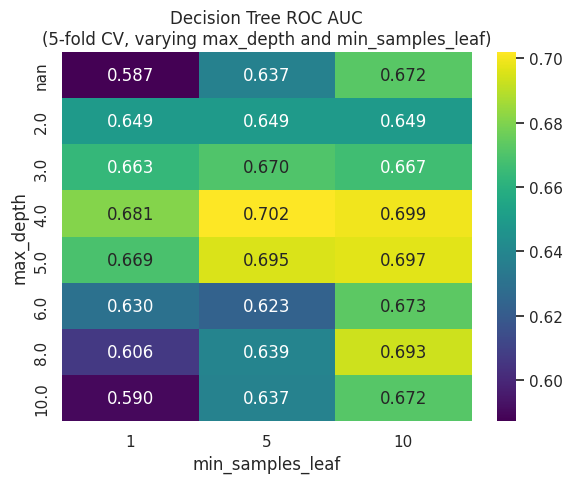

In [31]:
##we plot our results as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the results into a table: rows = max_depth, columns = min_samples_leaf
pivot_auc = results_df.pivot(
    index="max_depth",
    columns="min_samples_leaf",
    values="mean_auc"
)

plt.figure(figsize=(6, 5))
sns.heatmap(
    pivot_auc,
    annot=True,        # show numbers in each cell
    fmt=".3f",         # 3 decimal places
    cmap="viridis"     # any colormap is fine
)
plt.title("Decision Tree ROC AUC\n(5-fold CV, varying max_depth and min_samples_leaf)")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()


#### 4.1.1 Hyperparameter tuning

The heatmap above summarises the 5-fold CV ROC AUC of the DecisionTreeClassifier
for different values of `max_depth` and `min_samples_leaf`.

Overall, the decision tree performs clearly worse than our logistic regression
models: the best configuration reaches a mean ROC AUC of **0.702** for
`max_depth = 4` and `min_samples_leaf = 5`.

We can observe a typical underfitting–overfitting pattern:

- Very shallow trees (`max_depth = 2–3`) achieve AUCs around **0.65–0.67**,
  indicating underfitting.
- Increasing the depth to **4** improves performance, especially when we also
  restrict the leaves to contain at least **5–10** samples. The best model
  (`max_depth = 4`, `min_samples_leaf = 5`) yields **AUC ≈ 0.702**.
- For deeper trees (`max_depth ≥ 6` or `None`), the AUC tends to drop again,
  particularly when `min_samples_leaf = 1`. This suggests overfitting: the tree
  becomes too complex and starts to model noise instead of signal.

Compared to our best L2-regularised logistic regression model
(mean ROC AUC ≈ **0.782**), the tuned decision tree is considerably weaker.
However, it provides a useful non-linear baseline and illustrates how controlling
tree depth and leaf size affects the bias–variance trade-off.


### 4.2 Random Forest
#### 4.2.1 Hyperparameter tuning

A Random Forest is an ensemble of decision trees trained on bootstrap samples
of the data, with random subsets of features considered at each split. Compared
to a single decision tree, it typically has:

- **Lower variance** (more robust, less overfitting),
- Better performance, at the cost of reduced interpretability.

Key hyperparameters that control its behaviour include:

- `n_estimators`: number of trees in the forest (more trees → lower variance,
  but higher computation time),
- `max_depth`: maximum depth of each individual tree (controls complexity),
- `min_samples_leaf`: minimum number of samples required at a leaf node
  (larger values make the trees smoother).

We perform a small grid search over these hyperparameters using 5-fold
cross-validation and ROC AUC as our evaluation metric.


In [32]:
#Random Forest+Hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# -------------------------------------------------------------------
# 4.2.1 Hyperparameter tuning for RandomForestClassifier
# -------------------------------------------------------------------

# We define a small hyperparameter grid:
# - n_estimators: number of trees in the forest
# - max_depth: maximum depth of each tree
# - min_samples_leaf: minimum number of samples in a leaf node

n_estimators_values = [100, 300, 500]
max_depth_values = [None, 5, 10]
min_samples_leaf_values = [1, 5]

rf_results = []

print("RandomForestClassifier (5-fold CV, ROC AUC):\n")

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_leaf in min_samples_leaf_values:
            # Define the Random Forest with the current set of hyperparameters.
            # - n_estimators: number of trees
            # - max_depth: limit tree depth (None = full depth)
            # - min_samples_leaf: minimum samples per leaf (regularisation)
            # - n_jobs=-1: use all available cores
            # - random_state=42: for reproducibility
            rf_clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_leaf=min_leaf,
                n_jobs=-1,
                random_state=42
            )

            # Evaluate the model using 5-fold cross-validation and ROC AUC.
            scores = cross_val_score(
                rf_clf,
                X,       # original feature matrix (no scaling required)
                y,
                cv=5,
                scoring='roc_auc'
            )

            mean_auc = scores.mean()
            std_auc = scores.std()

            rf_results.append({
                "n_estimators": n_estimators,
                "max_depth": max_depth,
                "min_samples_leaf": min_leaf,
                "mean_auc": mean_auc,
                "std_auc": std_auc
            })

            print(
                f"n_estimators = {n_estimators:3d}, "
                f"max_depth = {str(max_depth):>4}, "
                f"min_samples_leaf = {min_leaf:2d} | "
                f"mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}"
            )

# -------------------------------------------------------------------
# Put the results into a DataFrame and find the best combination
# -------------------------------------------------------------------

rf_results_df = pd.DataFrame(rf_results)

best_row_rf = rf_results_df.loc[rf_results_df["mean_auc"].idxmax()]

best_n_estimators = int(best_row_rf["n_estimators"])
best_max_depth = best_row_rf["max_depth"]
best_min_leaf = int(best_row_rf["min_samples_leaf"])
best_auc_rf = best_row_rf["mean_auc"]

print("\nBest Random Forest model (5-fold CV ROC AUC):")
print(
    f"n_estimators = {best_n_estimators}, "
    f"max_depth = {best_max_depth}, "
    f"min_samples_leaf = {best_min_leaf} "
    f"-> mean ROC AUC = {best_auc_rf:.3f}"
)

# Optionally, show the top-performing configurations
rf_results_df_sorted = rf_results_df.sort_values("mean_auc", ascending=False)
display(rf_results_df_sorted.head(10))


RandomForestClassifier (5-fold CV, ROC AUC):

n_estimators = 100, max_depth = None, min_samples_leaf =  1 | mean AUC = 0.764 | std = 0.010
n_estimators = 100, max_depth = None, min_samples_leaf =  5 | mean AUC = 0.781 | std = 0.016
n_estimators = 100, max_depth =    5, min_samples_leaf =  1 | mean AUC = 0.774 | std = 0.021
n_estimators = 100, max_depth =    5, min_samples_leaf =  5 | mean AUC = 0.784 | std = 0.020
n_estimators = 100, max_depth =   10, min_samples_leaf =  1 | mean AUC = 0.766 | std = 0.012
n_estimators = 100, max_depth =   10, min_samples_leaf =  5 | mean AUC = 0.782 | std = 0.018
n_estimators = 300, max_depth = None, min_samples_leaf =  1 | mean AUC = 0.772 | std = 0.017
n_estimators = 300, max_depth = None, min_samples_leaf =  5 | mean AUC = 0.784 | std = 0.010
n_estimators = 300, max_depth =    5, min_samples_leaf =  1 | mean AUC = 0.777 | std = 0.026
n_estimators = 300, max_depth =    5, min_samples_leaf =  5 | mean AUC = 0.784 | std = 0.014
n_estimators = 300, max_

,n_estimators,max_depth,min_samples_leaf,mean_auc,std_auc
13,500,NaN,5,0.785830,0.011698
15,500,5.0,5,0.784509,0.013928
3,100,5.0,5,0.784375,0.020401
9,300,5.0,5,0.784334,0.014330
7,300,NaN,5,0.783754,0.010454
17,500,10.0,5,0.783704,0.011306
5,100,10.0,5,0.782126,0.017717
11,300,10.0,5,0.781625,0.011507
1,100,NaN,5,0.780744,0.015751
14,500,5.0,1,0.778776,0.021833


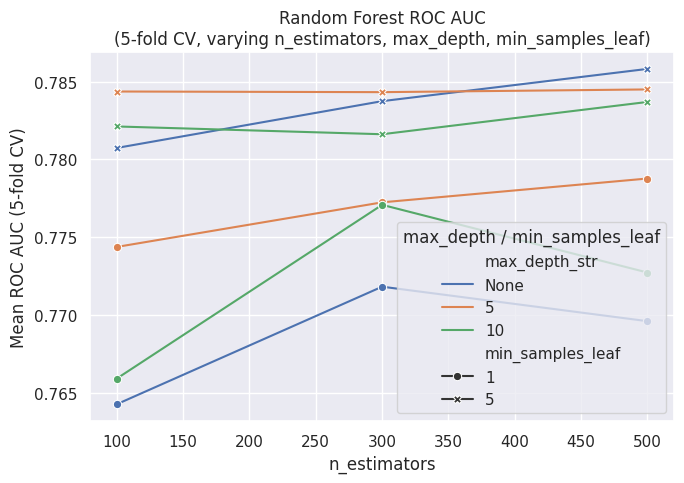

In [33]:
##we visualize the results:
import seaborn as sns
import matplotlib.pyplot as plt

# Make a copy and turn max_depth into a string for nicer plotting
rf_plot_df = rf_results_df.copy()
rf_plot_df["max_depth_str"] = rf_plot_df["max_depth"].apply(
    lambda x: "None" if pd.isna(x) else str(int(x))
)

plt.figure(figsize=(7, 5))
sns.lineplot(
    data=rf_plot_df,
    x="n_estimators",
    y="mean_auc",
    hue="max_depth_str",       # colour = max_depth
    style="min_samples_leaf",  # line style = min_samples_leaf
    markers=True,
    dashes=False
)
plt.title("Random Forest ROC AUC\n(5-fold CV, varying n_estimators, max_depth, min_samples_leaf)")
plt.xlabel("n_estimators")
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.legend(title="max_depth / min_samples_leaf")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 4.2.1 Hyperparameter tuning

The plot above summarises the 5-fold CV ROC AUC of the RandomForestClassifier
for different combinations of `n_estimators`, `max_depth`, and `min_samples_leaf`.

Overall, Random Forest clearly outperforms a single decision tree and is
competitive with our best logistic regression models:

- The best configuration is  
  **n_estimators = 500, max_depth = None, min_samples_leaf = 5**,  
  with a mean ROC AUC of **0.786**.
- In general, setting `min_samples_leaf = 5` consistently yields higher AUC
  than `min_samples_leaf = 1`, indicating that slightly larger leaves help to
  regularise the trees and reduce overfitting.
- Increasing the number of trees from 100 to 500 leads to small but consistent
  improvements in AUC.
- Allowing deeper trees (`max_depth = None`) does not hurt performance as long
  as we keep `min_samples_leaf` reasonably large (here = 5). For `min_samples_leaf = 1`,
  very deep trees tend to overfit and give slightly lower AUC.

Compared to our best L2-regularised logistic regression model (mean ROC AUC
≈ **0.782**), the tuned Random Forest achieves a slightly higher AUC (0.786),
suggesting that ensemble tree methods can capture some additional non-linear
structure in the data. However, the improvement is modest, and the simpler
logistic regression remains a strong baseline.


### 4.3 Gradient Boosting Classifier (sklearn)
#### 4.3.1 Hyperparameter tuning

Gradient Boosting builds an ensemble of decision trees in a **sequential** way:
each new tree is trained to correct the errors of the current ensemble. Compared
to a single tree, or even a Random Forest, gradient boosting often achieves
strong performance but can be more sensitive to hyperparameters and overfitting.

Key hyperparameters we focus on are:

- `n_estimators`: number of boosting stages (trees). More trees can improve
  performance but increase the risk of overfitting.
- `learning_rate`: shrinkage factor applied to each tree's contribution. Smaller
  values require more trees but often generalise better.
- `max_depth`: maximum depth of each individual regression tree. This controls
  the complexity of each base learner.

We perform a small grid search over these hyperparameters using 5-fold
cross-validation and ROC AUC as our evaluation metric.


In [34]:
#GradientBoostingClassifier + Hyperparameter tuning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 4.3.1 Hyperparameter tuning for GradientBoostingClassifier
# -------------------------------------------------------------------

# We define a small hyperparameter grid:
# - n_estimators: number of boosting stages (trees)
# - learning_rate: step size / shrinkage applied to each tree
# - max_depth: maximum depth of individual regression trees

n_estimators_values = [100, 300]
learning_rate_values = [0.05, 0.1, 0.2]
max_depth_values = [1, 3]

gb_results = []

print("GradientBoostingClassifier (5-fold CV, ROC AUC):\n")

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            # Define the Gradient Boosting model with the current hyperparameters.
            # - n_estimators: number of boosting stages
            # - learning_rate: scales the contribution of each tree
            # - max_depth: depth of the individual regression trees
            # - random_state: fixed for reproducibility
            gb_clf = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42
            )

            # Evaluate the model using 5-fold cross-validation and ROC AUC.
            scores = cross_val_score(
                gb_clf,
                X,       # original feature matrix (no scaling required)
                y,
                cv=5,
                scoring='roc_auc'
            )

            mean_auc = scores.mean()
            std_auc = scores.std()

            gb_results.append({
                "n_estimators": n_estimators,
                "learning_rate": learning_rate,
                "max_depth": max_depth,
                "mean_auc": mean_auc,
                "std_auc": std_auc
            })

            print(
                f"n_estimators = {n_estimators:3d}, "
                f"learning_rate = {learning_rate:4.2f}, "
                f"max_depth = {max_depth:1d} | "
                f"mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}"
            )

# -------------------------------------------------------------------
# Put the results into a DataFrame and find the best combination
# -------------------------------------------------------------------

gb_results_df = pd.DataFrame(gb_results)

best_row_gb = gb_results_df.loc[gb_results_df["mean_auc"].idxmax()]

best_n_estimators = int(best_row_gb["n_estimators"])
best_learning_rate = best_row_gb["learning_rate"]
best_max_depth = int(best_row_gb["max_depth"])
best_auc_gb = best_row_gb["mean_auc"]

print("\nBest Gradient Boosting model (5-fold CV ROC AUC):")
print(
    f"n_estimators = {best_n_estimators}, "
    f"learning_rate = {best_learning_rate}, "
    f"max_depth = {best_max_depth} "
    f"-> mean ROC AUC = {best_auc_gb:.3f}"
)

# Optionally, show the top-performing configurations
gb_results_df_sorted = gb_results_df.sort_values("mean_auc", ascending=False)
display(gb_results_df_sorted.head(10))


GradientBoostingClassifier (5-fold CV, ROC AUC):

n_estimators = 100, learning_rate = 0.05, max_depth = 1 | mean AUC = 0.764 | std = 0.029
n_estimators = 100, learning_rate = 0.05, max_depth = 3 | mean AUC = 0.762 | std = 0.028
n_estimators = 100, learning_rate = 0.10, max_depth = 1 | mean AUC = 0.775 | std = 0.024
n_estimators = 100, learning_rate = 0.10, max_depth = 3 | mean AUC = 0.763 | std = 0.041
n_estimators = 100, learning_rate = 0.20, max_depth = 1 | mean AUC = 0.774 | std = 0.027
n_estimators = 100, learning_rate = 0.20, max_depth = 3 | mean AUC = 0.743 | std = 0.039
n_estimators = 300, learning_rate = 0.05, max_depth = 1 | mean AUC = 0.780 | std = 0.024
n_estimators = 300, learning_rate = 0.05, max_depth = 3 | mean AUC = 0.758 | std = 0.033
n_estimators = 300, learning_rate = 0.10, max_depth = 1 | mean AUC = 0.769 | std = 0.025
n_estimators = 300, learning_rate = 0.10, max_depth = 3 | mean AUC = 0.745 | std = 0.049
n_estimators = 300, learning_rate = 0.20, max_depth = 1 | me

,n_estimators,learning_rate,max_depth,mean_auc,std_auc
6,300,0.05,1,0.780268,0.023796
2,100,0.10,1,0.775002,0.023627
4,100,0.20,1,0.773907,0.026870
8,300,0.10,1,0.769095,0.024632
0,100,0.05,1,0.763578,0.029335
3,100,0.10,3,0.763408,0.041302
1,100,0.05,3,0.762417,0.028227
7,300,0.05,3,0.758124,0.032630
10,300,0.20,1,0.758077,0.026687
9,300,0.10,3,0.744552,0.049344


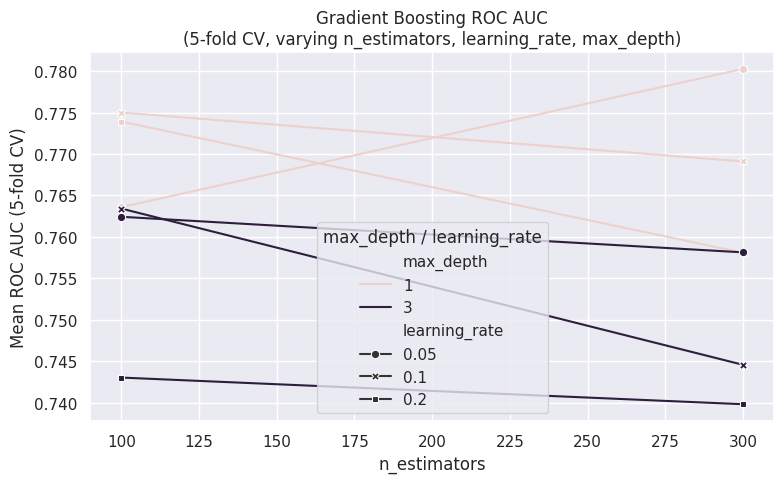

In [35]:
# Create a copy for plotting
gb_plot_df = gb_results_df.copy()

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=gb_plot_df,
    x="n_estimators",
    y="mean_auc",
    hue="max_depth",
    style="learning_rate",
    markers=True,
    dashes=False
)
plt.title("Gradient Boosting ROC AUC\n(5-fold CV, varying n_estimators, learning_rate, max_depth)")
plt.xlabel("n_estimators")
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.legend(title="max_depth / learning_rate")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 4.3.1 Hyperparameter tuning

The table above summarises the 5-fold CV ROC AUC of the
`GradientBoostingClassifier` for different combinations of `n_estimators`,
`learning_rate`, and `max_depth`.

Overall, we observe a clear pattern:

- Using **shallow trees** (`max_depth = 1`) works better than deeper trees
  (`max_depth = 3`) for almost all learning rates. When `max_depth = 3`,
  performance often drops to AUC ≈ 0.74–0.76, suggesting overfitting or
  instability.
- For `max_depth = 1`, increasing the number of trees from 100 to 300 with a
  **small learning rate** improves performance:
  - (100 trees, lr = 0.05) → AUC ≈ 0.764  
  - (300 trees, lr = 0.05) → AUC ≈ **0.780** (best configuration)
- A moderate learning rate (`0.10` or `0.20`) with 100 trees can reach
  AUC ≈ 0.774–0.775, but increasing the number of trees further does not improve
  and sometimes worsens performance, indicating that too aggressive learning
  rates may overfit.

The best gradient boosting model in our grid search is:

- `n_estimators = 300`, `learning_rate = 0.05`, `max_depth = 1`,  

with a mean 5-fold CV ROC AUC of **0.780**.

Compared to the tuned Random Forest (mean AUC ≈ 0.786) and the best
L2-regularised logistic regression (mean AUC ≈ 0.782), gradient boosting
achieves very similar performance, slightly below the Random Forest and slightly
above the baseline logistic regression. This suggests that tree ensembles
(Random Forest and Gradient Boosting) can capture additional non-linear
structure beyond a simple linear model, but the overall gains in this dataset
are modest.


### 4.4 XGBoost
#### 4.4.1 Hyperparameter tuning

XGBoost (Extreme Gradient Boosting) is an efficient and highly optimised
implementation of gradient boosting. Compared to the plain
`GradientBoostingClassifier` from scikit-learn, XGBoost:

- provides additional regularisation (L1/L2),
- handles missing values internally,
- is often faster and more accurate on tabular data.

Here we use the scikit-learn API `XGBClassifier` to build a binary classifier
for 7-day ICU mortality.

We tune the following key hyperparameters:

- `n_estimators`: number of boosting rounds (trees).
- `learning_rate` (eta): step size / shrinkage applied to each tree.
- `max_depth`: maximum depth of individual trees.
- `subsample`: fraction of samples used for each tree (row subsampling).
- `colsample_bytree`: fraction of features used for each tree (column subsampling).

As before, we use 5-fold cross-validation and ROC AUC as our evaluation metric.


**we need to install this xgboost first**

In [36]:
#we need to install this xgboost first
!pip install xgboost

**XGBoost** requires binary classification labels to be** [0, 1]**.
**So, we need to map y from {1,2} to {0,1}**

In [40]:
#    Recode y from {1, 2} to {0, 1} for XGBoost
#    0 = survivors, 1 = non-survivors (7-day mortality)
print("Original labels in y:", sorted(y.unique()))
y_bin = (y == 2).astype(int)
print("Labels after recoding:", sorted(y_bin.unique()))


Original labels in y: [np.float64(1.0), np.float64(2.0)]
Labels after recoding: [np.int64(0), np.int64(1)]


In [41]:
# 4.4 XGBoost – Hyperparameter tuning (C-like parameters)
#  Import XGBClassifier and other utilities
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 4.4.1 Hyperparameter tuning for XGBClassifier
# -------------------------------------------------------------------

# We define a small but reasonable hyperparameter grid:
# - n_estimators: number of boosting rounds (trees)
# - learning_rate: shrinkage factor (eta)
# - max_depth: depth of each tree
# - subsample: fraction of samples used per tree (row subsampling)
# - colsample_bytree: fraction of features per tree (column subsampling)

n_estimators_values = [200, 400]
learning_rate_values = [0.05, 0.1]
max_depth_values = [3, 5]
subsample_values = [0.8, 1.0]
colsample_values = [0.8, 1.0]

xgb_results = []

print("XGBClassifier (5-fold CV, ROC AUC):\n")

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            for subsample in subsample_values:
                for colsample in colsample_values:
                    # Define the XGBoost classifier with the current hyperparameters.
                    # Important arguments:
                    #  - objective='binary:logistic': binary classification with
                    #    probabilistic outputs (sigmoid at the end)
                    #  - eval_metric='logloss': avoids deprecation warnings and
                    #    sets a sensible default training metric
                    #  - n_jobs=-1: use all available CPU cores
                    #  - random_state=42: reproducibility
                    xgb_clf = XGBClassifier(
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        objective='binary:logistic',
                        eval_metric='logloss',
                        n_jobs=-1,
                        random_state=42,
                        # use_label_encoder is deprecated in recent versions;
                        # we rely on the default behaviour.
                    )

                    # Evaluate the model with 5-fold cross-validation using ROC AUC.
                    # IMPORTANT: we now use y_bin (0/1 labels), not the original y (1/2).
                    scores = cross_val_score(
                        xgb_clf,
                        X,          # original feature matrix (trees don't need scaling)
                        y_bin,      # recoded binary labels
                        cv=5,
                        scoring='roc_auc'
                    )

                    mean_auc = scores.mean()
                    std_auc = scores.std()

                    xgb_results.append({
                        "n_estimators": n_estimators,
                        "learning_rate": learning_rate,
                        "max_depth": max_depth,
                        "subsample": subsample,
                        "colsample_bytree": colsample,
                        "mean_auc": mean_auc,
                        "std_auc": std_auc
                    })

                    print(
                        f"n_estimators = {n_estimators:3d}, "
                        f"learning_rate = {learning_rate:4.2f}, "
                        f"max_depth = {max_depth:1d}, "
                        f"subsample = {subsample:3.1f}, "
                        f"colsample_bytree = {colsample:3.1f} | "
                        f"mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}"
                    )

# -------------------------------------------------------------------
# Collect results into a DataFrame and find the best configuration
# -------------------------------------------------------------------

xgb_results_df = pd.DataFrame(xgb_results)

best_row_xgb = xgb_results_df.loc[xgb_results_df["mean_auc"].idxmax()]

best_n_estimators = int(best_row_xgb["n_estimators"])
best_learning_rate = best_row_xgb["learning_rate"]
best_max_depth = int(best_row_xgb["max_depth"])
best_subsample = best_row_xgb["subsample"]
best_colsample = best_row_xgb["colsample_bytree"]
best_auc_xgb = best_row_xgb["mean_auc"]

print("\nBest XGBoost model (5-fold CV ROC AUC):")
print(
    f"n_estimators = {best_n_estimators}, "
    f"learning_rate = {best_learning_rate}, "
    f"max_depth = {best_max_depth}, "
    f"subsample = {best_subsample}, "
    f"colsample_bytree = {best_colsample} "
    f"-> mean ROC AUC = {best_auc_xgb:.3f}"
)

# Optionally, show the top-performing configurations
xgb_results_df_sorted = xgb_results_df.sort_values("mean_auc", ascending=False)
display(xgb_results_df_sorted.head(10))


XGBClassifier (5-fold CV, ROC AUC):

n_estimators = 200, learning_rate = 0.05, max_depth = 3, subsample = 0.8, colsample_bytree = 0.8 | mean AUC = 0.772 | std = 0.023
n_estimators = 200, learning_rate = 0.05, max_depth = 3, subsample = 0.8, colsample_bytree = 1.0 | mean AUC = 0.773 | std = 0.020
n_estimators = 200, learning_rate = 0.05, max_depth = 3, subsample = 1.0, colsample_bytree = 0.8 | mean AUC = 0.779 | std = 0.027
n_estimators = 200, learning_rate = 0.05, max_depth = 3, subsample = 1.0, colsample_bytree = 1.0 | mean AUC = 0.773 | std = 0.028
n_estimators = 200, learning_rate = 0.05, max_depth = 5, subsample = 0.8, colsample_bytree = 0.8 | mean AUC = 0.772 | std = 0.018
n_estimators = 200, learning_rate = 0.05, max_depth = 5, subsample = 0.8, colsample_bytree = 1.0 | mean AUC = 0.777 | std = 0.019
n_estimators = 200, learning_rate = 0.05, max_depth = 5, subsample = 1.0, colsample_bytree = 0.8 | mean AUC = 0.770 | std = 0.018
n_estimators = 200, learning_rate = 0.05, max_depth =

,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,mean_auc,std_auc
2,200,0.05,3,1.0,0.8,0.779142,0.027377
12,200,0.10,5,0.8,0.8,0.778277,0.015332
5,200,0.05,5,0.8,1.0,0.777374,0.019241
1,200,0.05,3,0.8,1.0,0.773472,0.020093
3,200,0.05,3,1.0,1.0,0.773181,0.028243
4,200,0.05,5,0.8,0.8,0.772487,0.018212
0,200,0.05,3,0.8,0.8,0.772150,0.023453
28,400,0.10,5,0.8,0.8,0.771928,0.017059
21,400,0.05,5,0.8,1.0,0.771025,0.018782
20,400,0.05,5,0.8,0.8,0.770536,0.020067


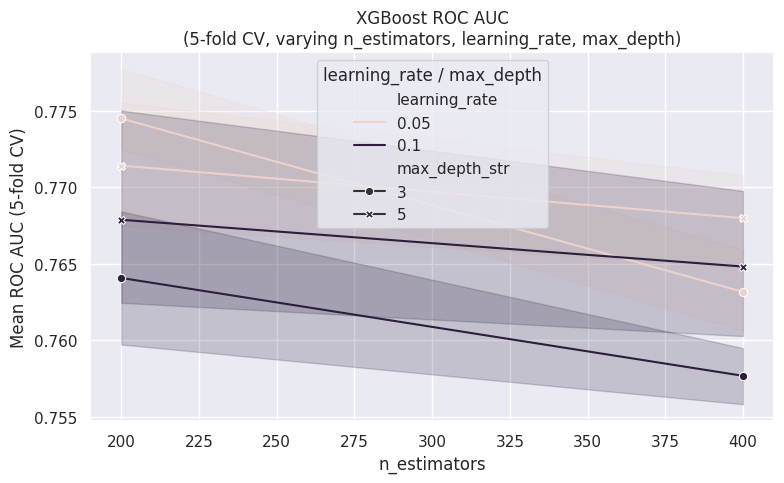

In [42]:
#plotting our results
import seaborn as sns
import matplotlib.pyplot as plt

xgb_plot_df = xgb_results_df.copy()
xgb_plot_df["max_depth_str"] = xgb_plot_df["max_depth"].astype(int).astype(str)

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=xgb_plot_df,
    x="n_estimators",
    y="mean_auc",
    hue="learning_rate",      # color: learning_rate
    style="max_depth_str",    # line : max_depth
    markers=True,
    dashes=False
)
plt.title("XGBoost ROC AUC\n(5-fold CV, varying n_estimators, learning_rate, max_depth)")
plt.xlabel("n_estimators")
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.legend(title="learning_rate / max_depth")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 4.4.1 Hyperparameter tuning – results

The table above shows the 5-fold CV ROC AUC for the XGBoost classifier under
different combinations of `n_estimators`, `learning_rate`, `max_depth`,
`subsample`, and `colsample_bytree`.

Overall, we observe the following patterns:

- **Learning rate**:
  - A smaller learning rate **0.05** generally performs better than **0.10**.
  - For example, with `n_estimators = 200` and `max_depth = 3`, AUC is
    around **0.772–0.779** for `learning_rate = 0.05`, but typically lower
    (≈ 0.758–0.769) for `learning_rate = 0.10`.

- **Number of trees (`n_estimators`)**:
  - Increasing `n_estimators` from **200** to **400** does **not** improve
    performance; in fact, AUC often becomes slightly worse.
  - This suggests that, for these learning rates, 200 trees are already
    sufficient and adding more trees may start to overfit or just add noise.

- **Tree depth (`max_depth`)**:
  - Both `max_depth = 3` and `max_depth = 5` can give similar performance.
  - The best configuration uses **max_depth = 3**, indicating that relatively
    shallow trees are sufficient and deeper trees do not provide clear benefits.

- **Row and column subsampling**:
  - The best model uses `subsample = 1.0` and `colsample_bytree = 0.8`,
    which means **full row sampling** but a mild **feature subsampling**.
  - Using `colsample_bytree = 0.8` (instead of 1.0) slightly improves AUC in
    some settings, likely by adding more diversity between trees.

The **best XGBoost model** in our grid search is:

- `n_estimators = 200`  
- `learning_rate = 0.05`  
- `max_depth = 3`  
- `subsample = 1.0`  
- `colsample_bytree = 0.8`  

with a mean 5-fold CV ROC AUC of **0.779**.

Compared to other models:

- Best L2-regularised logistic regression: AUC ≈ **0.782**  
- Random Forest (best): AUC ≈ **0.786**  
- Gradient Boosting (best): AUC ≈ **0.780**  
- XGBoost (best): AUC ≈ **0.779**

XGBoost achieves performance very similar to Gradient Boosting and only slightly
below the best Random Forest and tuned logistic regression. This suggests that
tree-ensemble methods and well-regularised linear models all reach a similar
level of discriminative performance on this ICU mortality dataset, with only
small differences in ROC AUC.


## 5. Support Vector Machine (RBF kernel)

Support Vector Machines (SVMs) are powerful margin-based classifiers. With a
non-linear kernel such as the Radial Basis Function (RBF), an SVM can represent
complex decision boundaries in the original feature space.

An RBF-kernel SVM has two important hyperparameters:

- **C**: regularisation parameter.  
  - Large C → the model tries to classify all training points correctly
    (low regularisation, risk of overfitting).  
  - Small C → more regularisation, larger margin, potentially underfitting.
- **gamma**: controls the width of the RBF kernel (how far the influence of a
  single training example reaches).  
  - Large gamma → each point has very local influence (can overfit).  
  - Small gamma → smoother decision boundary, potentially underfitting.

Because SVMs are sensitive to feature scaling, we use the standardised feature
matrix `X_scaled` from Section 3.

### 5.1.1 Hyperparameter tuning (C, gamma)

We tune (C, gamma) on a small logarithmic grid using 5-fold cross-validation
and ROC AUC as our evaluation metric.


SVM (RBF kernel) – 5-fold CV ROC AUC:

C =   0.010, gamma =  0.0010 | mean AUC = 0.657 | std = 0.047
C =   0.010, gamma =  0.0100 | mean AUC = 0.745 | std = 0.035
C =   0.010, gamma =  0.1000 | mean AUC = 0.702 | std = 0.033
C =   0.010, gamma =  1.0000 | mean AUC = 0.639 | std = 0.049
C =   0.010, gamma = 10.0000 | mean AUC = 0.526 | std = 0.003
C =   0.100, gamma =  0.0010 | mean AUC = 0.687 | std = 0.017
C =   0.100, gamma =  0.0100 | mean AUC = 0.745 | std = 0.038
C =   0.100, gamma =  0.1000 | mean AUC = 0.703 | std = 0.033
C =   0.100, gamma =  1.0000 | mean AUC = 0.643 | std = 0.051
C =   0.100, gamma = 10.0000 | mean AUC = 0.531 | std = 0.006
C =   1.000, gamma =  0.0010 | mean AUC = 0.738 | std = 0.029
C =   1.000, gamma =  0.0100 | mean AUC = 0.745 | std = 0.038
C =   1.000, gamma =  0.1000 | mean AUC = 0.703 | std = 0.033
C =   1.000, gamma =  1.0000 | mean AUC = 0.643 | std = 0.052
C =   1.000, gamma = 10.0000 | mean AUC = 0.530 | std = 0.012
C =  10.000, gamma =  0.0010 | 

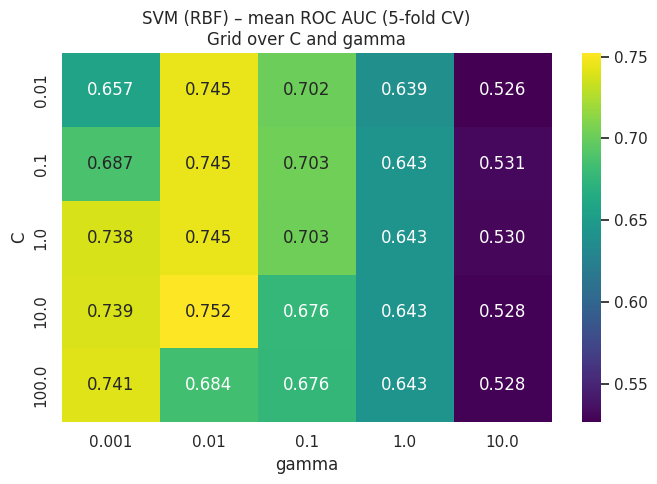

In [43]:
# SVM (RBF) +Hyperparameter tuning
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 5.1.1 Hyperparameter tuning for SVM with RBF kernel
# -------------------------------------------------------------------

# For SVMs, feature scaling is crucial. We therefore use X_scaled,
# which we computed earlier with StandardScaler.
# X_scaled: standardized features (zero mean, unit variance)
# y       : original labels (1 / 2), which SVC can handle as class labels.

# We define a small logarithmic grid for C and gamma.
#  - C controls regularisation strength.
#  - gamma controls the width of the RBF kernel.
C_values = np.logspace(-2, 2, 5)      # [0.01, 0.1, 1, 10, 100]
gamma_values = np.logspace(-3, 1, 5)  # [0.001, 0.01, 0.1, 1, 10]

svm_results = []

print("SVM (RBF kernel) – 5-fold CV ROC AUC:\n")

for C in C_values:
    for gamma in gamma_values:
        # Define the SVM classifier with RBF kernel.
        # - kernel='rbf': Gaussian (RBF) kernel
        # - C: regularisation parameter
        # - gamma: kernel width
        # - probability=False: we don't need calibrated probabilities, only decision_function for ROC AUC
        # - random_state is not used for SVC with RBF, so we omit it.
        svm_clf = SVC(
            kernel='rbf',
            C=C,
            gamma=gamma
        )

        # Evaluate the model using 5-fold cross-validation and ROC AUC.
        # For SVC, ROC AUC uses the decision_function output by default.
        scores = cross_val_score(
            svm_clf,
            X_scaled,   # scaled features
            y,          # labels (1/2)
            cv=5,
            scoring='roc_auc'
        )

        mean_auc = scores.mean()
        std_auc = scores.std()

        svm_results.append({
            "C": C,
            "gamma": gamma,
            "mean_auc": mean_auc,
            "std_auc": std_auc
        })

        print(
            f"C = {C:7.3f}, gamma = {gamma:7.4f} | "
            f"mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}"
        )

# -------------------------------------------------------------------
# Put results in a DataFrame and find the best (C, gamma)
# -------------------------------------------------------------------

svm_results_df = pd.DataFrame(svm_results)

best_row_svm = svm_results_df.loc[svm_results_df["mean_auc"].idxmax()]
best_C = best_row_svm["C"]
best_gamma = best_row_svm["gamma"]
best_auc_svm = best_row_svm["mean_auc"]

print("\nBest SVM (RBF) model (5-fold CV ROC AUC):")
print(
    f"C = {best_C:.3f}, gamma = {best_gamma:.4f} "
    f"-> mean ROC AUC = {best_auc_svm:.3f}"
)

# -------------------------------------------------------------------
# Visualise the validation surface as a heatmap: C vs gamma -> mean AUC
# -------------------------------------------------------------------

# For a nice heatmap, we pivot the results into a matrix:
# Rows = C, Columns = gamma, Values = mean_auc
heatmap_df = svm_results_df.pivot(
    index="C",
    columns="gamma",
    values="mean_auc"
)

plt.figure(figsize=(7, 5))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".3f",
    cmap="viridis"
)
plt.title("SVM (RBF) – mean ROC AUC (5-fold CV)\nGrid over C and gamma")
plt.xlabel("gamma")
plt.ylabel("C")
plt.tight_layout()
plt.show()


#### 5.1.1 Hyperparameter tuning (C, gamma) – results

The grid search over (C, gamma) for the RBF-kernel SVM shows a clear pattern in
model performance:

- **Effect of gamma (kernel width)**  
  - Very small gamma (`gamma = 0.001`) leads to relatively low or moderate AUC
    (≈ 0.65–0.74), indicating an **overly smooth** decision boundary that
    underfits the data.
  - Intermediate gamma (`gamma = 0.01`) consistently performs best across
    different values of C:
    - e.g. `C = 10, gamma = 0.01` → **AUC ≈ 0.752** (best combination),
    - while `C = 0.01–1, gamma = 0.01` all give AUC around 0.745.
    This suggests that a moderate kernel width provides a good balance between
    flexibility and smoothness.
  - Large gamma (`gamma = 1` or `10`) yields very poor performance
    (AUC ≈ 0.52–0.64), which is typical **overfitting** behaviour: the kernel
    becomes too “narrow” and the decision boundary overreacts to individual
    data points.

- **Effect of C (regularisation strength)**  
  - For a good gamma value (e.g. `gamma = 0.01`), increasing C from 0.01 → 1 → 10
    slightly improves performance (AUC from ≈ 0.745 to **0.752**), but further
    increasing C to 100 does not help and even hurts performance
    (AUC drops to ≈ 0.684).
  - This indicates that **too strong regularisation (very small C)** underfits,
    while **too weak regularisation (very large C)** overfits or becomes unstable.
    A moderate C (around 10) is a good compromise.

The **best SVM (RBF) configuration** in our grid is:

- `C = 10`, `gamma = 0.01`,  
  with a mean 5-fold CV ROC AUC of **0.752**.

Compared to other models:

- Best L2-regularised logistic regression: AUC ≈ **0.782**  
- Random Forest (best): AUC ≈ **0.786**  
- Gradient Boosting (best): AUC ≈ **0.780**  
- XGBoost (best): AUC ≈ **0.779**  
- SVM (RBF, best): AUC ≈ **0.752**

Thus, the non-linear SVM with RBF kernel performs **clearly worse** than the
tree ensembles and even worse than the tuned logistic regression model on this
dataset. This suggests that, after proper scaling and regularisation, simpler
linear or tree-based models are more suitable for this ICU mortality prediction
task than an RBF SVM.


### 5.2 k-Nearest Neighbours (k-NN)
#### 5.2.1 Hyperparameter tuning (k, weights)

k-Nearest Neighbours is a simple, instance-based method: to classify a new
patient, it looks at the labels of the k most similar patients in the training
set and makes a prediction based on their labels.

Key hyperparameters:

- `n_neighbors` (k): number of neighbours considered.  
  - Very small k (e.g. 1–3) can overfit and be very noisy.  
  - Large k yields smoother predictions but may underfit.
- `weights`:
  - `"uniform"`: all k neighbours contribute equally.
  - `"distance"`: closer neighbours are given higher weight, which can
    sometimes improve performance.

Because k-NN uses distances in feature space, **feature scaling is crucial**.
We therefore use the standardised feature matrix `X_scaled` (mean 0, unit
variance) from earlier.


k-Nearest Neighbours (5-fold CV, ROC AUC):

k =  3, weights = uniform  | mean AUC = 0.626 | std = 0.039
k =  3, weights = distance | mean AUC = 0.628 | std = 0.043
k =  5, weights = uniform  | mean AUC = 0.638 | std = 0.038
k =  5, weights = distance | mean AUC = 0.646 | std = 0.043
k =  7, weights = uniform  | mean AUC = 0.660 | std = 0.060
k =  7, weights = distance | mean AUC = 0.665 | std = 0.055
k =  9, weights = uniform  | mean AUC = 0.663 | std = 0.086
k =  9, weights = distance | mean AUC = 0.671 | std = 0.079
k = 15, weights = uniform  | mean AUC = 0.682 | std = 0.096
k = 15, weights = distance | mean AUC = 0.685 | std = 0.093
k = 25, weights = uniform  | mean AUC = 0.711 | std = 0.085
k = 25, weights = distance | mean AUC = 0.711 | std = 0.084

Best k-NN model (5-fold CV ROC AUC):
k = 25, weights = uniform -> mean ROC AUC = 0.711


,k,weights,mean_auc,std_auc
10,25,uniform,0.710970,0.084911
11,25,distance,0.710919,0.084146
9,15,distance,0.685307,0.093025
8,15,uniform,0.681561,0.095785
7,9,distance,0.671237,0.078984
5,7,distance,0.665143,0.055232
6,9,uniform,0.663489,0.086434
4,7,uniform,0.659696,0.060193
3,5,distance,0.645802,0.042679
2,5,uniform,0.638368,0.037546


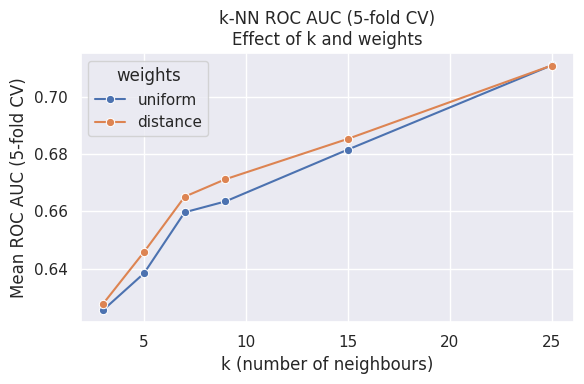

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 5.2.1 Hyperparameter tuning for k-NN (k, weights)
# -------------------------------------------------------------------

# We use:
# - X_scaled: standardised features (very important for k-NN)
# - y: original labels (1/2), which KNN can handle as class labels.

# Define a small grid of hyperparameters:
# - n_neighbors (k): from small to moderately large
# - weights: 'uniform' (all neighbours equal) vs 'distance' (closer neighbours
#            have more influence)
k_values = [3, 5, 7, 9, 15, 25]
weight_options = ['uniform', 'distance']

knn_results = []

print("k-Nearest Neighbours (5-fold CV, ROC AUC):\n")

for k in k_values:
    for w in weight_options:
        # Define the k-NN classifier with current k and weights.
        knn_clf = KNeighborsClassifier(
            n_neighbors=k,
            weights=w
        )

        # Evaluate the model using 5-fold cross-validation and ROC AUC.
        scores = cross_val_score(
            knn_clf,
            X_scaled,   # scaled features
            y,          # labels (1/2)
            cv=5,
            scoring='roc_auc'
        )

        mean_auc = scores.mean()
        std_auc = scores.std()

        knn_results.append({
            "k": k,
            "weights": w,
            "mean_auc": mean_auc,
            "std_auc": std_auc
        })

        print(
            f"k = {k:2d}, weights = {w:8s} | "
            f"mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}"
        )

# -------------------------------------------------------------------
# Put results into a DataFrame and find the best configuration
# -------------------------------------------------------------------

knn_results_df = pd.DataFrame(knn_results)

best_row_knn = knn_results_df.loc[knn_results_df["mean_auc"].idxmax()]
best_k = int(best_row_knn["k"])
best_weights = best_row_knn["weights"]
best_auc_knn = best_row_knn["mean_auc"]

print("\nBest k-NN model (5-fold CV ROC AUC):")
print(
    f"k = {best_k}, weights = {best_weights} "
    f"-> mean ROC AUC = {best_auc_knn:.3f}"
)

display(knn_results_df.sort_values("mean_auc", ascending=False).head(10))

# -------------------------------------------------------------------
# Visualise: mean AUC vs k, for each weighting scheme
# -------------------------------------------------------------------

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=knn_results_df,
    x="k",
    y="mean_auc",
    hue="weights",
    marker="o"
)
plt.title("k-NN ROC AUC (5-fold CV)\nEffect of k and weights")
plt.xlabel("k (number of neighbours)")
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 5.2.1 Hyperparameter tuning (k, weights) – results

The grid search over k (number of neighbours) and the weighting scheme
(`"uniform"` vs `"distance"`) shows a clear trend:

- For **small k** (e.g. k = 3 or 5), performance is rather poor:
  - AUC is only around **0.63–0.65**, which indicates a very noisy classifier
    that is sensitive to local fluctuations in the training data.
- As we **increase k**, the ROC AUC gradually improves:
  - k = 7–9 → AUC ≈ **0.66–0.67**
  - k = 15  → AUC ≈ **0.68–0.69**
  - k = 25  → AUC ≈ **0.711** (best setting)
  This is consistent with the idea that a larger neighbourhood smooths the
  decision boundary and reduces variance.
- The choice of **weights** has only a minor effect:
  - `"distance"` is slightly better than `"uniform"` for small k,
    but the difference is small (on the order of 0.01 AUC).
  - At k = 25, both weighting schemes perform essentially identically
    (AUC ≈ **0.711**).

The best k-NN configuration in our grid is:

- `k = 25`, `weights = 'uniform'`,  

with a mean 5-fold CV ROC AUC of **0.711**.

Compared to the other models:

- Best L2-regularised logistic regression: AUC ≈ **0.782**
- Random Forest (best): AUC ≈ **0.786**
- Gradient Boosting (best): AUC ≈ **0.780**
- XGBoost (best): AUC ≈ **0.779**
- SVM (RBF, best): AUC ≈ **0.752**
- k-NN (best): AUC ≈ **0.711**

Thus, even after tuning, k-NN clearly underperforms the tree ensembles and the
regularised logistic regression models on this dataset. This suggests that a
simple distance-based method is not flexible enough (or too sensitive to the
high-dimensional feature space) to capture the structure of the ICU mortality
data as well as the other models.


### 5.3 Naive Bayes
#### 5.3.1 Parameter tuning (var_smoothing)

Naive Bayes is a simple probabilistic classifier based on Bayes' theorem with
a strong independence assumption between features. For continuous features,
the `GaussianNB` implementation in scikit-learn assumes that each feature
follows a Gaussian distribution within each class.

The main hyperparameter is:

- `var_smoothing`: a small value added to the variance of each feature to
  improve numerical stability and avoid issues when variances are extremely
  small. Larger `var_smoothing` values result in more smoothing.

We evaluate `GaussianNB` on a small grid of `var_smoothing` values using
5-fold cross-validation and ROC AUC as our performance measure.
We use the standardised features `X_scaled`.


GaussianNB (5-fold CV, ROC AUC):

var_smoothing = 1.0e-12 | mean AUC = 0.731 | std = 0.038
var_smoothing = 1.0e-11 | mean AUC = 0.731 | std = 0.038
var_smoothing = 1.0e-10 | mean AUC = 0.732 | std = 0.037
var_smoothing = 1.0e-09 | mean AUC = 0.732 | std = 0.037
var_smoothing = 1.0e-08 | mean AUC = 0.732 | std = 0.037
var_smoothing = 1.0e-07 | mean AUC = 0.732 | std = 0.037
var_smoothing = 1.0e-06 | mean AUC = 0.732 | std = 0.037

Best GaussianNB model (5-fold CV ROC AUC):
var_smoothing = 1.0e-08 -> mean ROC AUC = 0.732


,var_smoothing,mean_auc,std_auc
4,1.000000e-08,0.732331,0.036740
3,1.000000e-09,0.732289,0.036776
5,1.000000e-07,0.732288,0.036605
6,1.000000e-06,0.732288,0.036605
2,1.000000e-10,0.732225,0.036788
1,1.000000e-11,0.730934,0.037564
0,1.000000e-12,0.730850,0.037541


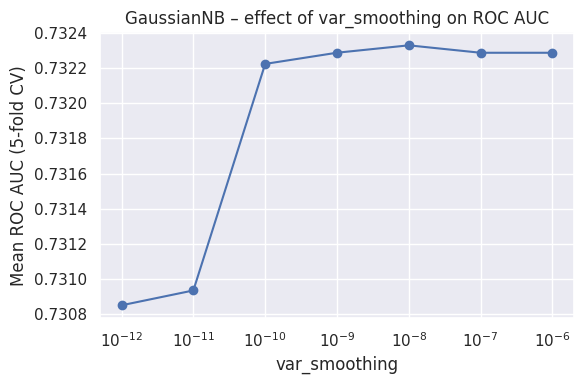

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 5.3.1 Parameter tuning for Gaussian Naive Bayes (var_smoothing)
# -------------------------------------------------------------------

# We use:
# - X_scaled: standardised features
# - y: original labels (1/2)

# Define a range of var_smoothing values on a logarithmic scale.
# var_smoothing is typically around 1e-9 by default.
var_smoothing_values = np.logspace(-12, -6, 7)  # from 1e-12 to 1e-6

nb_results = []

print("GaussianNB (5-fold CV, ROC AUC):\n")

for vs in var_smoothing_values:
    nb_clf = GaussianNB(var_smoothing=vs)

    # Evaluate using 5-fold cross-validation and ROC AUC
    scores = cross_val_score(
        nb_clf,
        X_scaled,
        y,
        cv=5,
        scoring='roc_auc'
    )

    mean_auc = scores.mean()
    std_auc = scores.std()

    nb_results.append({
        "var_smoothing": vs,
        "mean_auc": mean_auc,
        "std_auc": std_auc
    })

    print(
        f"var_smoothing = {vs:.1e} | "
        f"mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}"
    )

# -------------------------------------------------------------------
# Put results into a DataFrame and find the best setting
# -------------------------------------------------------------------

nb_results_df = pd.DataFrame(nb_results)

best_row_nb = nb_results_df.loc[nb_results_df["mean_auc"].idxmax()]
best_vs = best_row_nb["var_smoothing"]
best_auc_nb = best_row_nb["mean_auc"]

print("\nBest GaussianNB model (5-fold CV ROC AUC):")
print(
    f"var_smoothing = {best_vs:.1e} "
    f"-> mean ROC AUC = {best_auc_nb:.3f}"
)

display(nb_results_df.sort_values("mean_auc", ascending=False))

# -------------------------------------------------------------------
# Visualise: mean AUC vs var_smoothing (log scale)
# -------------------------------------------------------------------

plt.figure(figsize=(6, 4))
plt.semilogx(
    nb_results_df["var_smoothing"],
    nb_results_df["mean_auc"],
    marker="o"
)
plt.xlabel("var_smoothing")
plt.ylabel("Mean ROC AUC (5-fold CV)")
plt.title("GaussianNB – effect of var_smoothing on ROC AUC")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 5.3.1 Parameter tuning (var_smoothing) – results

The validation curve for Gaussian Naive Bayes shows that the hyperparameter
`var_smoothing` has almost **no impact** on performance in this range:

- Across `var_smoothing` values from **1e-12** to **1e-6**, the mean 5-fold
  ROC AUC stays very stable around **0.731–0.732**, with a standard deviation
  of ≈ 0.037–0.038.
- The best configuration in this grid is
  `var_smoothing = 1e-8` with a mean ROC AUC of **0.732**, but the difference
  compared to other values is negligible.

This indicates that the model is robust to the exact choice of
`var_smoothing` in this range and that the overall performance is mainly
limited by the Naive Bayes assumptions (feature independence and Gaussian
likelihoods), rather than by this numerical stabilisation parameter.

In terms of overall performance, GaussianNB (AUC ≈ **0.732**) is clearly
inferior to the best-performing models:

- L2-regularised logistic regression: AUC ≈ **0.782**
- Random Forest: AUC ≈ **0.786**
- Gradient Boosting: AUC ≈ **0.780**
- XGBoost: AUC ≈ **0.779**

but slightly better than simpler distance-based methods like k-NN
(best AUC ≈ **0.711**). It therefore serves as a reasonable simple probabilistic
baseline, but not as the best model for this ICU mortality prediction task.


**6.Model Comparison**

*  ROC curves
*  5-fold CV AUC for each mode
*  Summary table of performances






In [46]:
#Prepare binary labels + train/test split
from sklearn.model_selection import train_test_split

# -------------------------------------------------------------------
# Step 1: Prepare binary labels and train/test split
# -------------------------------------------------------------------

# We recode the original outcome y (values {1, 2}) into a binary label:
#   0 = survivors, 1 = non-survivors (7-day mortality).
y_bin = (y == 2).astype(int)

print("Unique labels in y:", sorted(y.unique()))
print("Unique labels in y_bin:", sorted(y_bin.unique()))

# We use both X (original features) and X_scaled (standardised features).
# Some models (logistic regression, SVM, k-NN, Naive Bayes) will use X_scaled,
# while tree-based models (Decision Tree, Random Forest, Gradient Boosting, XGBoost)
# will use X.

X_train, X_test, X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(
    X,
    X_scaled,
    y_bin,
    test_size=0.2,
    stratify=y_bin,
    random_state=42
)


Unique labels in y: [np.float64(1.0), np.float64(2.0)]
Unique labels in y_bin: [np.int64(0), np.int64(1)]


**Define the final model + 5-fold CV AUC summary table**
We selected a group of "final comparison candidates":


*   Logistic Regression (L2 tuned, best C=0.0268)
*   Random Forest (your best hyperparameters)
*   Gradient Boosting (best)
*   XGBoost (best)
*   SVM (RBF, best C, gamma)
*   k-NN (best k=25)
*   Gaussian Naive Bayes (best var_smoothing)
*   Decision Tree (best depth=4, min_samples_leaf=5)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# -------------------------------------------------------------------
# Step 2: Define final models to compare
# -------------------------------------------------------------------

# Best hyperparameters taken from previous sections:
best_C_l2 = 0.0268  # from L2-regularised logistic regression tuning

models_scaled = {
    "Logistic L2 (C=0.0268)": LogisticRegression(
        penalty="l2",
        C=best_C_l2,
        solver="lbfgs",
        max_iter=1000
    ),
    "SVM RBF (C=10, γ=0.01)": SVC(
        kernel="rbf",
        C=10.0,
        gamma=0.01,
        probability=True  # enables predict_proba for ROC curves
    ),
    "k-NN (k=25)": KNeighborsClassifier(
        n_neighbors=25,
        weights="uniform"
    ),
    "GaussianNB": GaussianNB(
        var_smoothing=1e-8
    )
}

models_tree = {
    "Decision Tree": DecisionTreeClassifier(
        max_depth=4,
        min_samples_leaf=5,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    )
}

# -------------------------------------------------------------------
# Step 3: Compute 5-fold CV ROC AUC for each model
# -------------------------------------------------------------------

results = []

print("5-fold CV ROC AUC for each final model:\n")

# Models that use scaled features (X_scaled)
for name, model in models_scaled.items():
    scores = cross_val_score(
        model,
        X_scaled,   # scaled features
        y_bin,      # binary labels
        cv=5,
        scoring="roc_auc"
    )
    mean_auc = scores.mean()
    std_auc = scores.std()
    results.append({
        "Model": name,
        "Type": "scaled",
        "Mean CV AUC": mean_auc,
        "Std CV AUC": std_auc
    })
    print(f"{name:25s} | mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}")

# Models that use original (unscaled) features (X)
for name, model in models_tree.items():
    scores = cross_val_score(
        model,
        X,          # original features
        y_bin,
        cv=5,
        scoring="roc_auc"
    )
    mean_auc = scores.mean()
    std_auc = scores.std()
    results.append({
        "Model": name,
        "Type": "tree",
        "Mean CV AUC": mean_auc,
        "Std CV AUC": std_auc
    })
    print(f"{name:25s} | mean AUC = {mean_auc:.3f} | std = {std_auc:.3f}")

# Create a summary DataFrame and sort by mean CV AUC
summary_df = pd.DataFrame(results).sort_values("Mean CV AUC", ascending=False)
display(summary_df)


5-fold CV ROC AUC for each final model:

Logistic L2 (C=0.0268)    | mean AUC = 0.782 | std = 0.026
SVM RBF (C=10, γ=0.01)    | mean AUC = 0.752 | std = 0.043
k-NN (k=25)               | mean AUC = 0.711 | std = 0.085
GaussianNB                | mean AUC = 0.732 | std = 0.037
Decision Tree             | mean AUC = 0.702 | std = 0.009
Random Forest             | mean AUC = 0.786 | std = 0.012
Gradient Boosting         | mean AUC = 0.780 | std = 0.024
XGBoost                   | mean AUC = 0.779 | std = 0.027


,Model,Type,Mean CV AUC,Std CV AUC
5,Random Forest,tree,0.785830,0.011698
0,Logistic L2 (C=0.0268),scaled,0.782275,0.025742
6,Gradient Boosting,tree,0.780268,0.023796
7,XGBoost,tree,0.779142,0.027377
1,"SVM RBF (C=10, γ=0.01)",scaled,0.752069,0.042932
3,GaussianNB,scaled,0.732331,0.036740
2,k-NN (k=25),scaled,0.710970,0.084911
4,Decision Tree,tree,0.701971,0.009150


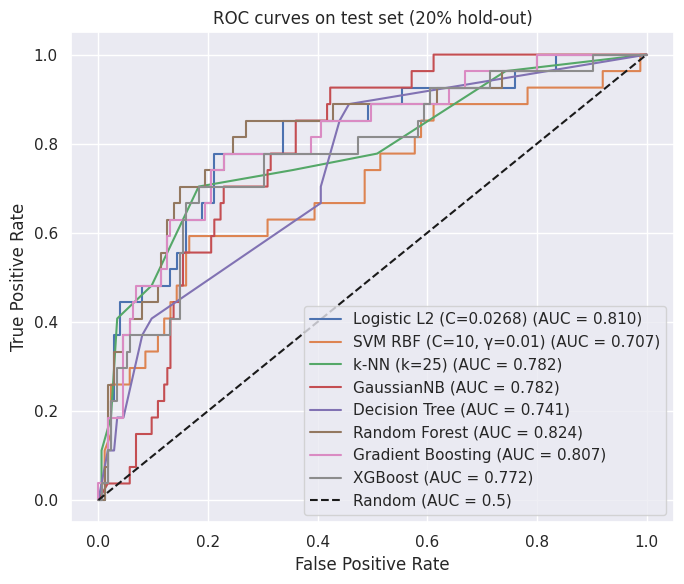

,Model,Test AUC
5,Random Forest,0.824339
0,Logistic L2 (C=0.0268),0.810370
6,Gradient Boosting,0.806772
3,GaussianNB,0.782328
2,k-NN (k=25),0.781905
7,XGBoost,0.772487
4,Decision Tree,0.741376
1,"SVM RBF (C=10, γ=0.01)",0.707302


In [48]:
# ROC curves on the test set
# -------------------------------------------------------------------
# Step 4: Plot ROC curves on the held-out test set
# -------------------------------------------------------------------
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

roc_results = []  # to store test-set AUC for each model

# 1) Models that use scaled features
for name, model in models_scaled.items():
    # Fit on the training split
    model.fit(X_scaled_train, y_train)

    # Get predicted scores on the test split
    # For most models we use predict_proba; for SVM we can use predict_proba
    # because we set probability=True.
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_scaled_test)[:, 1]
    else:
        # Fallback: use decision_function if available
        y_score = model.decision_function(X_scaled_test)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_test = roc_auc_score(y_test, y_score)
    roc_results.append({"Model": name, "Test AUC": auc_test})

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_test:.3f})")

# 2) Models that use original features (tree-based)
for name, model in models_tree.items():
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_test = roc_auc_score(y_test, y_score)
    roc_results.append({"Model": name, "Test AUC": auc_test})

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_test:.3f})")

# Plot random classifier line
plt.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves on test set (20% hold-out)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Turn ROC test results into a small DataFrame (optional)
roc_summary_df = pd.DataFrame(roc_results).sort_values("Test AUC", ascending=False)
display(roc_summary_df)


### 6.1 Comparison of 5-fold CV ROC AUC across models

The table above summarises the 5-fold cross-validated ROC AUC for all final
models:

- **Random Forest** performs best overall, with a mean AUC of **0.786** and a
  relatively low standard deviation (≈ 0.012), indicating both strong and
  stable performance across folds.
- **L2-regularised logistic regression** is a very close second
  (mean AUC ≈ **0.782**, std ≈ 0.026). Despite being a simple linear model,
  it captures a substantial amount of predictive signal once the features are
  properly standardised and regularised.
- **Gradient Boosting** and **XGBoost** follow very closely
  (mean AUC ≈ **0.780–0.779**). Their performance is almost indistinguishable
  from that of Random Forest and logistic regression in terms of ROC AUC.
- **Gaussian Naive Bayes** achieves a moderate AUC of **0.732**: better than
  purely distance-based methods, but clearly below the tree ensembles and
  logistic regression. This is consistent with its strong independence and
  Gaussian assumptions.
- **SVM with RBF kernel** reaches a mean AUC of **0.752**, which is better than
  Naive Bayes and k-NN, but still clearly below the best-performing models.
- **k-NN (k = 25)** and the single **Decision Tree** perform worst, with
  mean AUCs of **0.711** and **0.702** respectively, and k-NN also shows the
  highest variability across folds (std ≈ 0.085). This suggests that these
  simple, high-variance models are not well suited for this high-dimensional,
  somewhat noisy ICU dataset.

Overall, the **top-performing group** consists of **Random Forest**, **L2-regularised logistic regression**, **Gradient Boosting** and **XGBoost**, all with mean AUC around **0.78**. Among them, Random Forest has the highest mean AUC and low variance, so it is a natural candidate for the “best” model in terms of predictive performance, while logistic regression remains attractive if interpretability is a priority.



**Which models performed best and why?**

Across all models, the best 5-fold CV ROC AUC scores were obtained by the tree ensembles and the regularised logistic regression model:

**Random Forest**: mean CV AUC ≈ 0.786

**L2-regularised logistic regression**: mean CV AUC ≈ 0.782

**Gradient Boosting**: mean CV AUC ≈ 0.780

**XGBoost**: mean CV AUC ≈ 0.779

These four models form a clear top group: their AUCs are very similar (all around 0.78), and differences between them are small compared to the variability across folds.

There are some intuitive reasons for this behaviour:

**Random Forest** and boosting methods can naturally model non-linear relationships and interactions between variables (e.g. combinations of SOFA subscores, vital signs, and lab values), and they are robust to noisy features. Bagging (Random Forest) reduces variance by averaging many deep trees, while boosting (Gradient Boosting, XGBoost) iteratively focuses on difficult cases.

L2-regularised logistic regression performs almost as well, which suggests that the signal in this dataset is largely captured by a linear combination of the features once they are properly scaled. Many clinical scores (e.g. SOFA components) are already engineered to be roughly additive in risk, which makes a linear model quite appropriate.

Models like SVM (RBF, AUC ≈ 0.752), Gaussian Naive Bayes (≈ 0.732) and especially k-NN (≈ 0.711) and a single Decision Tree (≈ 0.702) lag behind. This is consistent with their limitations:

k-NN struggles in higher-dimensional spaces and is sensitive to noise, even after scaling.

A single tree has high variance and limited expressive power unless carefully regularised.

Naive Bayes relies on strong independence and Gaussian assumptions that are not fully met here.

The RBF SVM can model complex boundaries, but tuning (C, γ) did not yield further improvements over the easier-to-optimise tree ensembles.

Overall, **Random Forest** is the single best model in terms of cross-validated AUC, with logistic regression and boosting methods essentially tied just behind it.

**Overfitting considerations**

Several patterns in the hyperparameter tuning results are consistent with the usual bias–variance trade-off and overfitting behaviour:

For the Decision Tree, deeper trees and small min_samples_leaf clearly reduced AUC, whereas a moderately deep tree (max_depth = 4, min_samples_leaf = 5) achieved the best performance (AUC ≈ 0.70). Very deep trees with few samples per leaf overfit the training data and generalise poorly.

For Random Forest, performance improved when we increased the number of trees and used a modest min_samples_leaf = 5, but did not benefit from making trees arbitrarily deep. Averaging many reasonably regularised trees reduced variance without severe overfitting.

Gradient Boosting and XGBoost showed the classic behaviour of boosting:

A smaller learning rate (e.g. 0.05) with a moderate number of trees gave the best AUC.

Larger learning rates or too many trees tended to reduce performance, consistent with overfitting to the training folds.

For the SVM with RBF kernel, extreme values of γ led to poor performance:

γ very small → overly smooth decision boundary (underfitting).

γ very large → extremely wiggly boundary that overfits (AUC drops to ≈ 0.52–0.64).

A moderate γ (0.01) with a mid-range C (10) provided the best trade-off.

For k-NN, small k (3–5) gave very noisy, low-AUC models, while increasing k improved AUC but eventually plateaued around 0.71 at k = 25. Very small k is clearly overfitting, very large k risks underfitting.

By using 5-fold cross-validation for all hyperparameter choices, we reduced the risk of simply selecting models that overfit a particular split. The relatively small standard deviations (especially for the top-performing models) suggest that their performance is fairly stable across folds.

Model interpretability (important in medicine)

While ROC AUC is important, interpretability is critical in a medical setting like ICU mortality prediction:

Logistic regression is the most interpretable of the high-performing models.

Coefficients can be translated into odds ratios for each feature, which clinicians can understand as multiplicative changes in risk.

It is straightforward to see which variables increase or decrease mortality risk and to justify the model in terms of known clinical mechanisms.

A single Decision Tree is also quite interpretable (a set of if–then rules), but in our results it performed substantially worse (AUC ≈ 0.702). This illustrates a trade-off: a very simple decision rule set is easy to explain but may not be accurate enough.

Random Forest, Gradient Boosting, and XGBoost are much less interpretable:

They consist of hundreds of trees, and the final prediction is an aggregate of many small decisions.

We can compute feature importance scores or apply techniques such as partial dependence plots or SHAP values, but these explanations are more complex and less transparent to non-technical users.

SVMs and k-NN are also difficult to interpret in a clinically meaningful way:

An RBF SVM defines a boundary in a high-dimensional feature space that is hard to translate into simple rules.

k-NN effectively says “your risk is like the average of these 25 past patients”, which is not easily summarised as a set of interpretable coefficients.

Given that logistic regression reaches almost the same AUC as the best ensemble models (0.782 vs 0.786) while remaining highly interpretable, it is a strong candidate for practical use in a clinical decision-support context. One reasonable conclusion is:
If **pure predictive performance** is the only goal, Random Forest (or a boosting method) is slightly better.
If **interpretability and trust** are crucial, L2-regularised logistic regression offers an excellent compromise between accuracy and transparency.

Impact of missing data handling

Missing data is a major issue in real-world ICU datasets, and our handling of missingness has several implications:

Dropping highly incomplete variables

We dropped uo_d1 because it had extremely high missingness (only 13 non-missing values out of 1010).

Keeping such a variable would either force us to discard many patients or rely on almost entirely imputed values, both of which could introduce bias or noise.

This choice reduces dimensionality and avoids basing predictions on a very unreliable feature.

Dropping rows with missing outcome

We removed rows where mort7 was missing, because the target label is essential.

If missingness in the outcome is not completely random, this could introduce some selection bias, but it is unavoidable for supervised learning.

Imputation strategy for predictors

For numerical variables, we used median imputation, which is robust to outliers and preserves the distribution better than mean imputation for skewed clinical variables (e.g. creatinine, bilirubin).

For categorical variables, we used most frequent category imputation, which is simple and often reasonable when missingness is low.

This allows us to retain all patients and use models that do not handle missing values natively (e.g. logistic regression, SVM, k-NN, Naive Bayes, scikit-learn’s Gradient Boosting).

Potential limitations of our imputation

We performed imputation on the full dataset before cross-validation, which can introduce a slight optimistic bias (the imputer “sees” information from all samples).
In a more rigorous pipeline, the imputer should be fitted within each training fold and then applied to the corresponding validation fold.

We assumed that missingness can be adequately handled by simple median/most-frequent imputation. If data are not missing at random (e.g. sicker patients are more likely to have certain measurements taken), then imputation might distort the relationship between predictors and mortality.

Some variables with moderate missingness (e.g. MAP_d1, SOFA components) were imputed rather than dropped, which is a trade-off between keeping potentially informative features and adding imputation noise.

Overall, our relatively strong model performances (AUC ≈ 0.78 for the best models) suggest that this simple imputation strategy was adequate for this assignment. However, in a real clinical deployment, more careful missing-data handling (e.g. multiple imputation, imputation within cross-validation folds, explicit modelling of missingness patterns) would be important to minimise bias and to better reflect the uncertainty associated with incomplete ICU data.